# Top NJ Zip Codes: Zillow Data + Time Series Forecasting  

Introductory notes: 
* The focus here was less on traditional asset managers (mutual funds) and more on hedge funds, private equity funds, and other institutional alternative asset managers. 
* Intuition is that roles and culture are different at a Blackrock (4K reviews, 40K employees) and at Blackstone (500 reviews, 1000 employees) although both are considered behemoths in their respective spaces. 
* Several of the largest names in the space have very few glassdoor reviews, ie: Tiger Global Viking Global Farallon HPS Partners 
* Full list of firms [here](https://www.peregrinecommunications.com/hubfs/Reports/Alts-50-Report-2021-Peregrine-Communications.pdf)


## Data
* Zillow Data: ZHVI price data by zip code  
* More information on ZHVI [here]()

## Import Libraries <a id='import'></a>

In [1]:
import pandas as pd
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot

import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

import itertools

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm 

from pmdarima.arima import ADFTest
from pmdarima.arima import auto_arima

import pickle

import requests

import folium

import warnings
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')

### Get NJ Zip Code GEO Json Data 

In [2]:
# r = requests.get('https://raw.githubusercontent.com/OpenDataDE/State-zip-code-GeoJSON/master/nj_new_jersey_zip_codes_geo.min.json')
# data = r.json()

# with open('nj_geo_json.pickle', 'wb') as f:
#     pickle.dump(data, f)

In [3]:
with open('nj_geo_json.pickle','rb') as f:
    nj_geo_json = pickle.load(f)

## Define Methods

In [4]:
"""
Check a series for stationarity
Use Augmented Dickey-Fuller unit root test 
visualize rolling mean and standard deviation 
"""
def stationarity_check(df):
    
    roll_mean = df.rolling(window=12, center=False).mean()
    roll_std = df.rolling(window=12,center=False).std()
    
    dftest = adfuller(df)
    
    fig = plt.figure(figsize=(12,6))
    plt.plot(df, color='blue',label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling mean and std')
    plt.show(block=False)
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value', '#lags used', 'number of observations used'])
    for k, v in dftest[4].items():
        dfoutput['Critical Value (%s)'%k] = v
    print(dfoutput)


"""
Grid search for best pdq value based on aic 
Only include AIC scores with RMSE in the bottom 75% to account for low AIC scores with very high error 
return two tuples containing optimal pdq and pdqs values for fitting in SARIMAX model 
"""
def get_pdqs(df, train, seasonal=12, optimize='aic', display=True):   
    # p d and q can be 0, 1 or 2
    p = d = q = range(0, 2)

    # Generate all different combinations of p (autogressive terms), d (differencing), and q (moving average terms)
    pdq = list(itertools.product(p, d, q))

    # do the same with seasonal 
    # default 12: this data has a yearly seasonal component  
    pdqs = [(x[0], x[1], x[2], seasonal) for x in list(itertools.product(p, d, q))]

    # Takes the permutations above and runs a grid search to find the model with the lowest AIC score 
    output = []
    for combo in pdq:
        for combo_seasonal in pdqs:
            results = train_sarimax(train, pdq=combo, PDQS=combo_seasonal, errors=False, summary=False, diagnostics=False)
            if results:
                aic = results.aic 
                test = split_train_test(df)[1]
    #                 rmse = cv_score(df, pdq=combo, PDQS=combo_seasonal, splits=3)
                rmse = test_dynamic_predictions(train, test, pdq=combo, PDQS=combo_seasonal, display=False)

                output.append([combo, combo_seasonal, rmse, aic]) 

                if display:
                    print(f'pdq: {combo}; pdqs: {combo_seasonal}, RMSE: {rmse}, AIC: {aic}')

    # Find the parameters with minimal AIC value\
    # ensure that all values are in less than 75th percentile in terms of error, and look for the lowest aic 
    output_df = pd.DataFrame(output, columns=['pdq', 'pdqs', 'rmse', 'aic']) 
    output_df = output_df[output_df.rmse < np.percentile(output_df.rmse, 75)]
    output_df = output_df.sort_values(by='aic')
#     print('min AIC value:')
#     print(output_df[output_df.aic == output_df.aic.min()]['pdq'])
    
    if optimize == 'aic':
        pdq = tuple(output_df[output_df.aic == output_df.aic.min()]['pdq'].values[0])
        PDQS = tuple(output_df[output_df.aic == output_df.aic.min()]['pdqs'].values[0])
        
    else: 
        pdq = tuple(output_df[output_df.rmse == output_df.rmse.min()]['pdq'].values[0])
        PDQS = tuple(output_df[output_df.rmse == output_df.rmse.min()]['pdqs'].values[0])

    return output_df, pdq, PDQS 





""" 
Train an ARIMA model using pdq and PDQS parameters specified 
First: attempts to fit a model while enforcing stationarity and invertibility 
If this doesn't work, fits a model without enforcing invertibility 
returns fitted model 
"""
def train_sarimax(df, pdq=(0,2,2), PDQS=(0,0,0,12), errors=True, summary=False, diagnostics=False):
    arima_mod = sm.tsa.statespace.SARIMAX(df, order=pdq, seasonal_order=PDQS, 
                                          enforce_stationarity=True, 
                                          enforce_invertibility=True)
    
    try:
        results = arima_mod.fit(maxiter=500)
        # if log likelihood is 0 
        if results.llf == 0.0: 
            if errors:
                print('LinAlgError, \'Singular matrix\'. returning None')
                return None
            else:
                return None 

    except Exception as exception:
        if errors:
            print(f'Error. Couldn\'t train model. Returning None', exception)
            return None
        else:
            return None 
    
    if diagnostics:
        try:
            results.plot_diagnostics(figsize=(14,10))
        except: 
            if errors:
                print('Errors with diagnostics')
            return None
        
    # if training works return results and display  
    if summary and results:
        try:
            print(results.summary())
        except:
            print('Error printing summary. Did not find results.')
    
    return results 



def train_sarimax_non_enforced(df, pdq=(0,2,2), PDQS=(0,0,0,12)):
    
    arima_mod = sm.tsa.statespace.SARIMAX(df, order=pdq, seasonal_order=PDQS, 
                          enforce_stationarity=True, 
                          enforce_invertibility=False)
    results = arima_mod.fit(maxiter=250)
    
    return results 


""" 
takes in string and splits data
date entered is included in the train data 
"""
def split_train_test(df, split='2020-01-01'):
    return df.loc[:split], df.loc[pd.to_datetime(split) + pd.DateOffset(months=1):]


"""
Get the RMSE for training data
Takes in a fitted ARIMA model, and train data 
Makes predictions for the time specified as period and returns rmse 
"""

def train_results_rmse(results, train, period=24, display=True):
    # predict going back from 2 years, or other time specified 
    train_predict = results.predict(-period)
    
    # visualize results, plot train vs. predicted values 
    if display:
        fig,ax=plt.subplots(figsize=(12,5))
        train.plot(ax=ax, label='train actual')
        # plot one step ahead predictions 
        train_predict.plot(ax=ax, style='r--', label='one step ahead forecast')
        legend=ax.legend(loc='lower right')

    rmse = np.sqrt(mean_squared_error(train_predict, train[-period:])) 
    
    if display:
        print(f'\nTraining RMSE: {rmse}')
    
    return rmse 


"""
Walk forward validation on test data
returns RMSE 
"""
def test_results_rmse(train, test, pdq=(1,1,1), PDQS=(1,1,1,12), display=True):

    # walk-forward validation
    predictions=[]
    history = [x for x in train.values]
    actuals = test.values   
    
    # get the beginning and ending dates for matching exogenous data 
    # starting_date = train.index[0]
    # ending_date = train.index[-1]

    for t in range(len(test)):
        # add 1 month for every t to the ending date 
        # offset = 1 if t > 0 else 0 
        # ending_date = ending_date + pd.offsets.DateOffset(months=offset)
        
            
        results = train_sarimax(history, pdq=pdq, PDQS=PDQS, summary=False)
        
        if results is None:
            print('results is none.')
            y_hat = output
            predictions.append(output[0])
            actual = actuals[t]
            history.append(actual)
        else:

            output=results.forecast()
            y_hat = output[0]
            predictions.append(y_hat)
            actual = actuals[t]
            history.append(actual)
            #print('predicted: {}, expected: {}'.format(y_hat, actual))
    
    # convert predictions from list to series so rmse can be calculated 
    predictions = pd.Series(predictions, index=test.index)

    rmse = np.sqrt(mean_squared_error(actuals, predictions))
     
    if display:
        fig,ax=plt.subplots(figsize=(12,5))
        test.plot(ax=ax, label='test actuals')
        predictions.plot(ax=ax, style='r--', label='predictions')
        legend=ax.legend(loc='lower right')
        plt.title('Walk Forward Test Validation')
        plt.show()
        print(f'Test RMSE: {rmse}')

    return rmse


"""
Takes in a dataframe, test data, pdqs
trains an ARIMA model on df data 
Gets the dynamic predictions starting from the beginning of the test 
returns RMSE using test results 
displays graph of actuals vs. predictions 
"""
def test_dynamic_predictions(df, test, pdq, PDQS, display=True):
    # dynamic prediction 
    # df_exog = exog.loc[df.index[0]:df.index[-1]] if exog is not None else None 
    results = train_sarimax(df, pdq=pdq, PDQS=PDQS, summary=False, diagnostics=False)
    
    if not results:
        print('results didnt work')
    
    dynamic_pred = results.get_prediction(start=test.index[0], end=test.index[-1], dynamic=True)
    predictions = dynamic_pred.predicted_mean
    actuals = test.values 
    pred_ci = dynamic_pred.conf_int()
    
    # visualize test vs. dynamic predictions 
    if display:
        fig,ax=plt.subplots(figsize=(12,5))
    #     plt.plot(train['2014-01-01':], label='training')
        test.plot(ax=ax, label='test actuals')
        predictions.plot(ax=ax, style='r--', label='dynamic forecast')
        ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.12, label='confidence interval')
        plt.title('Test Dynamic Forecast vs. Test Actuals')
        legend=ax.legend(loc='lower right')
        plt.show()
    
    # get the rmse and return 
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    
    if display:
        print(f'RMSE: {rmse}')
    
    return rmse 


"""
Takes in a dataframe, pdqs, and a list of years to forecast default: [1,3,5,10]
trains an ARIMA model on df data 
Gets the dynamic predictions ending after each of the years in the forecast list 
Calculates and returns ROI and prices  
displays graph of forecast 
"""

def forecast_results(df, pdq=(1,1,1), PDQS=(1,1,1,12), years=[1,3,5,10], display=False):
    
    # retrain new model on all data
    results = train_sarimax(df, pdq=pdq, PDQS=PDQS)

    # get the last date in the data
    start_date = df.index[-1]

    forecasted_prices = []
    forecasted_rois = []

    for yr in [1,3,5,10]:
        # get the actual current price  
        current_actual = df.loc[start_date] 

        # add yr to the current date 
        end_date = start_date + pd.DateOffset(years=yr)

        # get dynamic predictions, values and the final prediction at the end of the series 
        dynamic_pred = results.get_prediction(start=start_date, end=end_date)

        predictions = dynamic_pred.predicted_mean 
        final_prediction = predictions[-1]

        # add the forecasted price after yr to the list 
        forecasted_prices.append(final_prediction) 

        # get confidence interval 
        pred_ci = dynamic_pred.conf_int()

        # get the ROI multiple 
        roi = (final_prediction - current_actual)/current_actual 
        forecasted_rois.append(roi)
        
        if display:
            print(f'Current price: ${current_actual}, Price after {yr} year(s): ${final_prediction.round(2)}')
            print(f'ROI for {yr} year(s):{roi}\n')
    
    if display:
        # plot 10 years of predictions 
        fig,ax=plt.subplots(figsize=(12,5))
        predictions.plot(ax=ax, label='test actuals')
        ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.12, label='confidence interval')
        plt.title('10 Year Forecast')
        legend=ax.legend(loc='lower right')
        plt.show()
        
    return current_actual, forecasted_prices, forecasted_rois
    

"""
Build ARIMA model and calculate forecasts for a single zip code 
Displays plots of train and test results, as well as forecasts 
"""
def single_zip_analysis(df, z, split='2020-05-31', display=True):
    current_zip = df[df.zip == z]['price']
    print(f'Splitting at {split}')
    train, test = split_train_test(current_zip, split=split)
    
    print(f'Getting results for zip: {z}')
    output_df, pdq, PDQS = get_pdqs(current_zip, train, optimize='aic', display=False) 
    
    print(pdq, PDQS)
    
    print('training sarimax')
    results = train_sarimax(train, pdq=pdq, PDQS=PDQS, summary=display, diagnostics=display)
    
    # if there is an error with training, change the split until there is no error
    # try a max of x times 
    max_tries = 10 
    try_count = 0
    
    while results is None and try_count <= max_tries:
        new_split = pd.to_datetime(split) + pd.DateOffset(months=1)
        train, test = split_train_test(current_zip, split = new_split)
        print(f'changing split. New split is {new_split}')
        
        output_df, pdq, PDQS = get_pdqs(current_zip, train, optimize='aic', display=False) 
            
        results = train_sarimax(train, pdq=pdq, PDQS=PDQS, summary=display, diagnostics=display)
        try_count += 1 
        split = new_split
        
    
    split, train, test, results = check_dynamic_rmse(current_zip, pdq, PDQS, split, train, test, results)

    
    # get the results for train, test and dynamic predictions     
    train_results = train_results_rmse(results, train, display=display)
    test_results = test_results_rmse(train, test, pdq=pdq, PDQS=PDQS, display=display)
    
    # use entire df and get dynamic results 
    dynamic_test_results = test_dynamic_predictions(current_zip, test, pdq, PDQS, display=display)
    
    # forecast results 
    forecast_results(current_zip, pdq=pdq, PDQS=PDQS, display=True)
    
    
 
 
"""
For a given zip code, collate all relevant information and return a dataframe 
"""
def organize_results(current_zip, output_df_, train_results_, test_results_, dynamic_test_results_, current_actual_, forecasted_prices_, forecasted_rois_):

    output_df = output_df_.sort_values(by='aic', ascending=True)

    # create new dataframe with results 
    df = pd.DataFrame(output_df.iloc[0]).T
    df['train_rmse'] = train_results_
    df['test_rmse'] = test_results_
    df['dynamic_rmse'] = dynamic_test_results_
    
    # add most recent price
    df['current_price'] = current_actual_
    
    # add new columns for each forecasted price and ROI 
    for price, yr in zip(forecasted_prices_, [1,3,5,10]):
        df[f'forecast_{yr}yr_price'] = price

    for roi, yr in zip(forecasted_rois_, [1,3,5,10]):
        df[f'forecast_{yr}yr_roi'] = roi
    
    df['zip'] = current_zip
    
    return df


"""
Take in a dataframe of many states and return only records in NJ 
Drops regiontype and statename columns 
prints number of unique zip codes 
"""
def get_nj(df):    
    nj = df[df.State == 'NJ']
    
    # for zhvi data 
    try:
        nj = nj.drop(['RegionType','StateName'], axis=1)
    except:
        pass 
    
    print('{} unique zip codes in NJ'.format(nj.RegionName.nunique()))
    return nj 


"""
Drops any missing values 
"""    
def drop_missing(df):
    missing = df.isna().sum().values.sum() 
    if missing > 0:
        print(f'{missing} missing values.')

    df = df.dropna()
    return df

    
"""
Take in a dataframe and melts 
Returns dataframe with columns renamed and time along the x axis as index 
"""    
def melt_df(df):
   
    melted = pd.melt(df,id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    
    
    if melted.isna().sum().values.sum() > 0:
        print('missing values present.')
    
    df = melted[['RegionName','SizeRank','City','Metro','CountyName','time','value']].rename(columns={'RegionName':'zip',
                                                                                                      'value':'price',
                                                                                                      'SizeRank':'size_rank',
                                                                                                      'City':'city',
                                                                                                      'Metro':'metro',
                                                                                                      'CountyName':'county'}).set_index('time')
    return df 

""" 
input: dataframe with dates 
output: dataframe with dates changed to first of month 
"""
def first_of_month(df):
    df = df.reset_index()
    col = df.columns[0]
    df[col] = df[col] - pd.offsets.MonthBegin(1)
    df = df.set_index('time')
    return df 

"""
Take in a dataframe 
Plots acf and pacf plots with given number of lags
"""    
def acf_pacf(df, nlags=36):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
    plot_acf(nj_avg_m, ax=ax[0], lags=nlags)
    plot_pacf(nj_avg_m, ax=ax[1], lags=nlags)
    ax[0].set_ylim(-1.0,1.1)
    ax[1].set_ylim(-1.0,1.1)
    plt.show()
    

"""
Takes in a datafram
trains models on all zips in dataframe 
output: dataframe with results of all zip codes 
"""
def get_results(df, split='2020-05-31', display=True):
    results_df = pd.DataFrame()

    zips = list(df.zip.unique())

    for z in zips:  
        # create a df for each zip 
        current_zip = df[df.zip == z]['price']

        # train test split
        # split='2020-01-01' default 
        train, test = split_train_test(current_zip, split=split)

        print(f'\nGetting results for zip: {z}')

        # get the optimal params 
        print('getting PDQs')
        output_df, pdq, PDQS = get_pdqs(current_zip, train, optimize='aic', display=False) 

        # train model using params
        print('Getting results with PDQs')
        results = train_sarimax(train, pdq=pdq, PDQS=PDQS, summary=False, diagnostics=False)
                
        # try a max of x times 
        max_tries = 10 
        try_count = 0

        while results is None and try_count <= max_tries:
            new_split = pd.to_datetime(split) + pd.DateOffset(months=1)
            train, test = split_train_test(df, split = new_split)
            print(f'changing split because results are none. New split is {new_split}')

            output_df, pdq, PDQS = get_pdqs(df, train, optimize='aic', display=False) 

            results = train_sarimax(train, pdq=pdq, PDQS=PDQS, summary=display, diagnostics=display)
            try_count += 1 
            split = new_split          
        
        split, train, test, results = check_dynamic_rmse(current_zip, pdq, PDQS, split, train, test, results)
        
        # get the results for train, test and dynamic predictions 
        train_results = train_results_rmse(results, train, display=False)
        test_results = test_results_rmse(train, test, pdq=pdq, PDQS=PDQS, display=False)

        # use entire df and get dynamic results 
        dynamic_test_results = test_dynamic_predictions(current_zip, test, pdq, PDQS, display=True)

        # forecast results 
        current_price, forecasted_prices, forecasted_rois = forecast_results(current_zip, pdq=pdq, PDQS=PDQS, display=False)

        # organize the results into a dataframe 
        current_df = organize_results(z, output_df, train_results, 
                                      test_results, dynamic_test_results,
                                      current_price, forecasted_prices, forecasted_rois)

        # aggregate zip codes together 
        results_df = pd.concat([results_df, current_df])

    results_df = results_df.set_index('zip')
    return results_df

"""
Check the rmse of the dynamic predictions of a given set of results, and train/test split 
if the predictions are further of than a threshold, change the split of the data and get new pdqs for a new model 
Output new split, train data, test data, and results from an arima model 
"""
def check_dynamic_rmse(df, pdq, PDQS, split, train, test, results, threshold=25000, max_tries=10):
        dynamic_rmse = test_dynamic_predictions(df, test, pdq, PDQS, display=False)

        
        if dynamic_rmse < threshold:
            return split, train, test, results
        
        try_count = 0
        max_tries = max_tries 
        
        dynamic_rmse_dict = {}
        dynamic_rmse_dict[dynamic_rmse] = [split, train, test, results]
        
        while dynamic_rmse > threshold and try_count <= max_tries:
            new_split = pd.to_datetime(split) + pd.DateOffset(months=1)
            new_split = new_split.strftime('%Y-%m-%d')
            train, test = split_train_test(df, split = new_split)      
            print(f'changing split due to dynamic rmse. New split is {new_split}')

            output_df, pdq, PDQS = get_pdqs(df, train, optimize='aic', display=False) 
            results = train_sarimax(train, pdq=pdq, PDQS=PDQS, summary=False, diagnostics=False)
            dynamic_rmse = test_dynamic_predictions(df, test, pdq, PDQS, display=False)
            split = new_split
            
            dynamic_rmse_dict[dynamic_rmse] = [split, train, test, results]

            try_count +=1 
            
            lowest_dynamic_rmse = np.min(list(dynamic_rmse_dict.keys()))
            
            split, train, test, results = dynamic_rmse_dict[lowest_dynamic_rmse][0], dynamic_rmse_dict[lowest_dynamic_rmse][1],\
            dynamic_rmse_dict[lowest_dynamic_rmse][2], dynamic_rmse_dict[lowest_dynamic_rmse][3]
        
        return split, train, test, results
    




"""
takes in a df with zipcodes and prices
for each zip code, calculates the ROI over the entire dataset  
returns a dataframe with num_results zip codes sorted by highest ROI  
"""
def rankby_total_roi(df, num_results):
    # get the roi of a series 
    def roi(series):
        return (series.iloc[-1] - series.iloc[0]) / series.iloc[0]
    
    # rank the zips by roi 
    zip_roi = df.groupby('zip').agg({'price':roi}).rename(columns={'price':'roi'}).reset_index().sort_values(by='roi', ascending=False)
    
    # get only the top num_results zips 
    zips = list(zip_roi.iloc[:num_results,:].zip.unique())
    
    # take original dataframe and filter by only zips above 
    result = df.loc[df['zip'].isin(zips)]
    
    return result 

"""
Takes in a df with zipcodes and prices
for each zip code, calculates the average yearly roi  
returns a df with num_results zip codes sorted by highest roi
"""
## Median annual ROI 
def rankby_median_annual_roi(df,num_results):
    
    # get the average annual roi of a series 
    def annual_roi(series):
        years = list(df.index.year.unique())
        annual_rois = []
        for index, year in enumerate(years):
            curr_index = int(index * 12) 
            if curr_index != 0:
                curr_year = series.iloc[curr_index]
                prev_year = series.iloc[curr_index - 12]
                annual_roi = (curr_year - prev_year) / prev_year
                annual_rois.append(annual_roi)
        return np.median(annual_rois)
    
    # rank the zips by ROI 
    zip_roi = df.groupby('zip').agg({'price':annual_roi}).rename(columns={'price':'median_annual_roi'}).reset_index()
    
    # get only the top num_results zips 
    zips = list(zip_roi.iloc[:num_results,:].zip.unique())
    
    # take original dataframe and filter by only zips above 
    result = df.loc[df['zip'].isin(zips)]
    
    return result

"""
Takes in a df with zipcodes
Gets the ROI for each zipcode over the past time_horizon years 
returns a DF ranking the top num_results zipcodes 
"""
# Short Term Returns 
def rankby_time_roi(df, time_horizon=3,num_results=10):
    
    def short_roi_calc(series):
        index = series.index[-1] - pd.Timedelta(days=(365*time_horizon))
        index = pd.Timestamp(year=index.year, month=series.index[-1].month,day=series.index[-1].day)
        return (series.iloc[-1] - series[index]) / series[index]
   
    zip_roi = df.groupby('zip').agg({'price':short_roi_calc}).rename(columns={'price':f'{time_horizon}_year_roi'}).reset_index().sort_values(by=f'{time_horizon}_year_roi', ascending=False)
    
    # get only the top num_results zips 
    zips = list(zip_roi.iloc[:num_results,:].zip.unique())
    
    # take original dataframe and filter by only zips above 
    result = df.loc[df['zip'].isin(zips)]
    
    return result 


"""
Takes in a df with zipcodes
Gets the coefficient of variation for each zipcode 
returns a DF ranking the top num_results zipcodes (lowest variance)
"""
# Risk/Volatility 
# lowest risk 
def rankby_volatility(df,num_results):
    
    # get the coefficient of variation for a time series 
    def cv_calc(series):
        coef_variation = series.std() / series.mean()
        return coef_variation 
    
    zip_cv = df.groupby('zip').agg({'price':cv_calc}).reset_index().sort_values(by='price', ascending=True).rename(columns={'price':'cv'})
    
    # get only the top num_results zips 
    zips = list(zip_cv.iloc[:num_results,:].zip.unique())
    
    # take original dataframe and filter by only zips above 
    result = df.loc[df['zip'].isin(zips)]
    
    return result 



"""
Takes in a df with zipcodes
returns df with the monthly percent change and the monthly roi for each zip code 
"""

def add_roi(df):
    top_25_pct = pd.DataFrame()

    for z in df.zip.unique():
        curr_df = df[df.zip == z]
        curr_df['monthly_roi'] = curr_df.price.pct_change()
        curr_df['monthly_roi'].iloc[0] = 0.00
        curr_df['roi_multiple'] = curr_df.price.pct_change() + 1.0
        curr_df['roi_multiple'].iloc[0] = 1.00

        top_25_pct = pd.concat([top_25_pct, curr_df])

    # rearrange so dataframe can be further analyzed 
    # if sorted by zip then can't use time indexing 
    top_25_pct = top_25_pct.reset_index().sort_values(by='time',ascending=True)
    top_25_pct = top_25_pct.set_index('time')
    
    return top_25_pct

"""
takes in df with zipcodes
starting location: Clifton, NJ 
returns a folium choropath map with only zip codes included in dataset 
col_feature: feature along which to categorize the zip codes 
"""

def map_zips(df, geo_json, starting_location=[40.876273867858565, -74.17184661470814], title='NJ Zip Codes', color='PuRd', col_feature=None):
    
    temp_df = df.copy()
    # 0 was removed when converting to integer 
    temp_df.zip = "0" + temp_df.zip.astype('str')
    zip_lst = list(temp_df.zip.unique()) # get only the relevant zips 
    
    # edit the data to only include the final 50 zips 
    data_final = {}
    data_final['type'] = geo_json['type']
    features_lst = []
    
    # add the data from the geo json to the features list for each relevant zip code 
    for f in geo_json['features']:
        # get the zip code in the geo json 
        z = f['properties']['ZCTA5CE10']
        if z in zip_lst:
            features_lst.append(f)

    data_final['features'] = features_lst 
    
    m = folium.Map(location=starting_location, zoom_start=10,
               tiles='https://server.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Light_Gray_Base/MapServer/tile/{z}/{y}/{x}',
              attr="Tiles &copy; Esri &mdash; Esri, DeLorme, NAVTEQ")

    if col_feature:
        cols = ["zip", col_feature]
    else:
        cols = ["zip","size_rank"]

    folium.Choropleth(
        geo_data=data_final,
        data=temp_df,
        columns=cols,
        key_on="feature.properties.ZCTA5CE10",
        fill_color=color,
        fill_opacity=0.8,
        line_opacity=0.5,
        legend_name=title,
        height=200,
        width=200
    ).add_to(m)

    return m
    




## Overall NJ Analysis / Initial EDA

### Preprocess Data and Get NJ Average
* Median prices for all NJ houses

In [5]:
data = pd.read_csv('zhvi_sfh_all.csv')

# select only zip codes in NJ 
nj = get_nj(data)

# prepare for time series analysis 
df_melted = melt_df(nj)

# change all dates to first of month to make them easier to use exogenous variables later 
df_month = first_of_month(df_melted)

northern_counties = ['Sussex County','Warren County', 'Hunterdon County','Somerset County','Middlesex County','Union County',
                     'Morris County','Essex County','Hudson County','Bergen County','Passaic County']

df = df_month[df_month.county.apply(lambda x: x in northern_counties)]

# get the median prices for all house in NJ 
nj_avg = df[['price']].groupby('time').price.median().reset_index().set_index('time')

560 unique zip codes in NJ
missing values present.


### Missing Values

In [ ]:
missing_dict = {}
for r in df.iterrows():
    zip_name = r[1]['zip']
    price = r[1]['price']
    index = r[0]
    
    if pd.isna(price):
        if zip_name in missing_dict:
            missing_dict[zip_name].append(index.strftime('%Y-%m'))
        else:
            missing_dict[zip_name] = [index.strftime('%Y-%m')]
    
null_zips = pd.DataFrame.from_dict(missing_dict.items())
null_zips.columns = ['zip','missing']
null_zips['missing_count'] = null_zips['missing'].apply(lambda x: len(x))
null_zips[['zip','missing_count']]

zip  missing_count
0   7102            169
1   7513            181
2   8886            149
3   7088            192
4   8832            193
5   7074            130
6   7606            169
7   7620            106
8   7976            109
9   7822            123
10  7878            108
11  8553            109
12  8858            170
13  7926            181
14  7977            169
15  7935            157
16  8528            225
17  8821            169
18  7851            181
19  7646              1
20  7043              2
21  7004              1
22  7030              1
23  7093              1
24  7305              1
25  7047              1
26  7462              1
27  8865              1
28  7450              2
29  7922              1
30  7452              2
31  7648              1
32  7024              1
33  7010              1
34  7650              1
35  7607              1
36  7432              2
37  8831              1
38  7827              1
39  7439              1
40  7601              3
41  7410              1
42  7657              1
43  7981              1
44  7401              1
45  7008              1

In [8]:
temp_df = df.copy()
temp_df = temp_df.reset_index()

zips_many_missing = null_zips[null_zips.missing.apply(lambda x: len(x) > 10)].zip.values

for i, r in temp_df.iterrows():
    zip_name = r['zip']
    price = r['price']
    
    if zip_name in zips_many_missing: 
        if pd.isna(price):
            temp_df.at[i, 'price'] =  nj_avg.loc[r['time']].price

final_df = temp_df.set_index('time')
final_df.isna().sum()

zip           0
size_rank     0
city          0
metro         0
county        0
price        33
dtype: int64

In [9]:
#fill rest of missing values 
final_df['price'].fillna(method='bfill',inplace=True)
final_df.isna().sum()

zip          0
size_rank    0
city         0
metro        0
county       0
price        0
dtype: int64

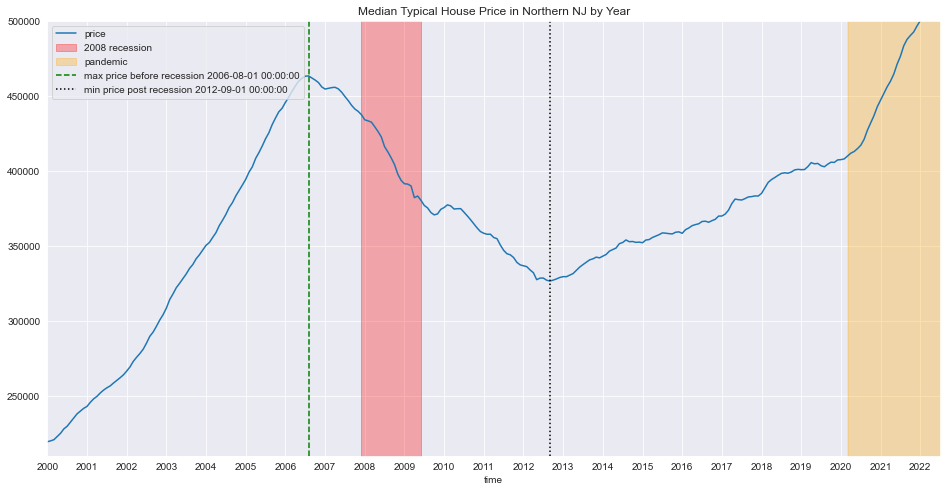

In [343]:
# Recession = December 2007 – June 2009
# ZHVI - # “typical” home value for a region
fig,ax = plt.subplots(figsize=(16,8))
xticks = pd.date_range('2000-01-01', '2022-01-01', freq='YS')
xticklabels = [x.strftime('%Y') for x in xticks]
nj_avg.plot(ax=ax, label='typical house price', xticks=xticks)

recession = nj_avg.loc['2007-12-01':'2009-06-01']
pandemic = pd.date_range('2020-03-01', '2022-07-01')
min_recession = nj_avg.loc['2008':'2014'].price.idxmin()
max_overall = nj_avg.loc[:'2009-06-01'].price.idxmax()

# plot rectangle for recession and for pandemic 
ax.fill_between(recession.index, ax.get_ylim()[0], 500000, color='red', alpha=0.3, label='2008 recession')
ax.fill_between(pandemic, ax.get_ylim()[0], 500000, color='orange', alpha=0.3, label='pandemic')

# plot lines 
ax.axvline(max_overall, ls='--', color = 'green', label=f'max price before recession {max_overall}')
ax.axvline(min_recession, ls=':', color = 'black', label=f'min price post recession {min_recession}')

ax.set_ylim(210000,500000)
ax.set_xticklabels(xticklabels)

legend=ax.legend(loc='upper left')

plt.title('Median Typical House Price in Northern NJ by Year')
plt.show()

<AxesSubplot:xlabel='time'>

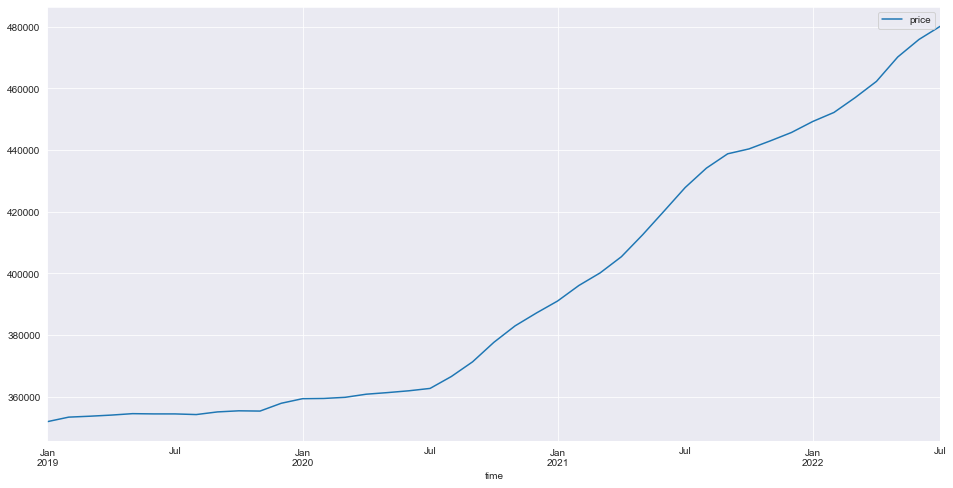

In [68]:
fig,ax = plt.subplots(figsize=(16,8))
nj_avg['2019':'2022'].plot(ax=ax, label='typical house price')

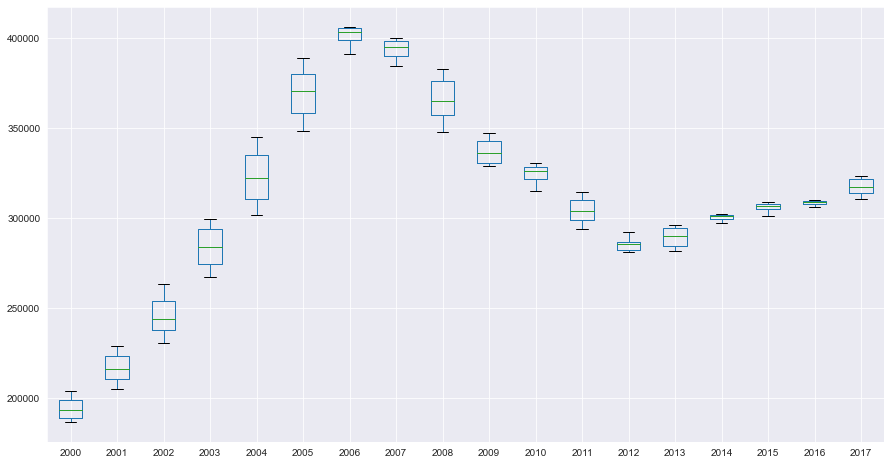

In [62]:
# not full years in 96 and 2018 
year_groups = nj_avg['1997':'2017'].groupby(pd.Grouper(freq='A'))
temp_annual = pd.DataFrame()
for yr, group in year_groups:
    temp_annual[yr.year] = group.values.ravel()
# temp_annual.plot(figsize=(32,24),subplots=True, legend=True)
# plt.show()

temp_annual.boxplot(figsize=(15,8))
plt.show()

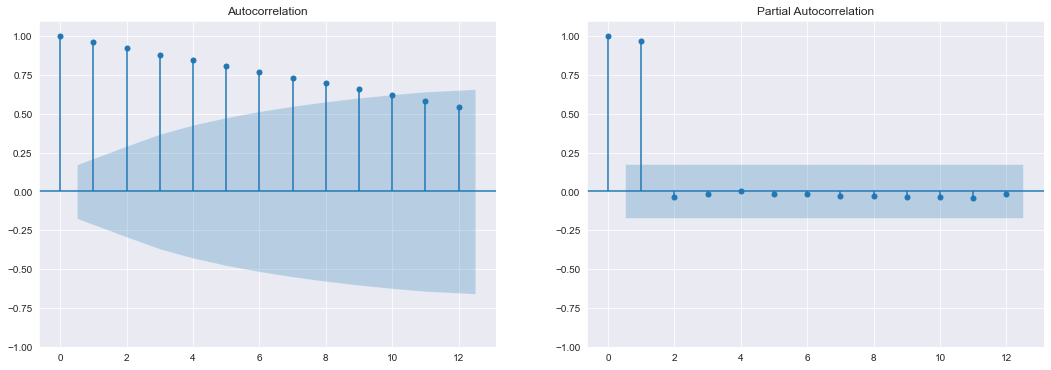

In [118]:
acf_pacf(nj_avg, nlags=12)

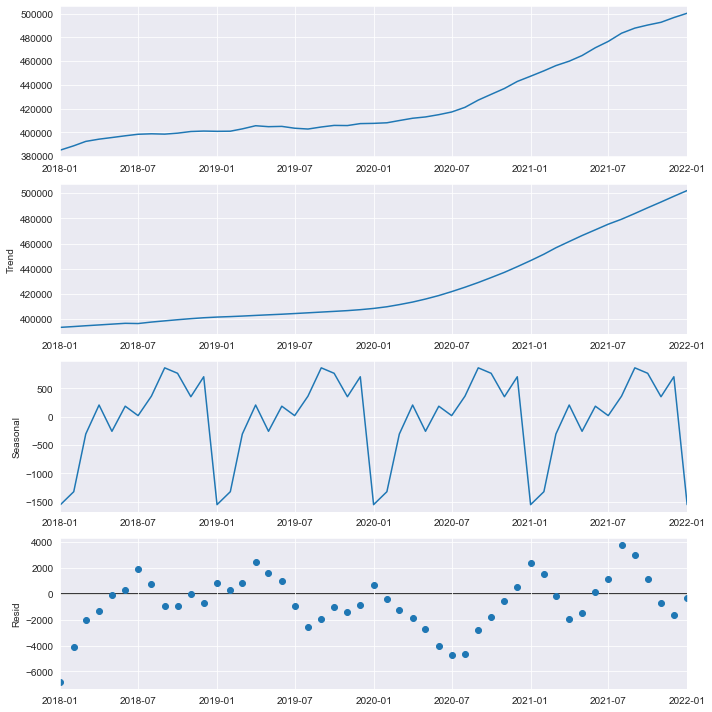

In [344]:
result_add = seasonal_decompose(nj_avg['2018':'2022-01-01'], model='additive', extrapolate_trend='freq')
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot().suptitle('', fontsize=22)
plt.show()

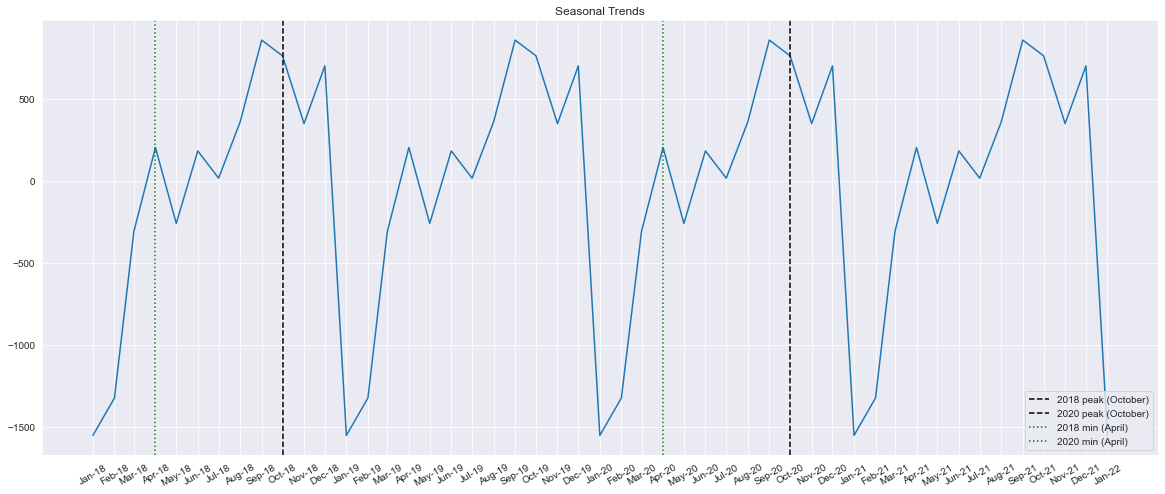

In [345]:
result_add = seasonal_decompose(nj_avg['2018':'2022-01-01'], model='additive', extrapolate_trend='freq')
fig, ax = plt.subplots(figsize=(20,8))

xticks = pd.date_range('2018-01-01', '2022-01-01', freq='MS')
xticklabels = [x.strftime('%b-%y') for x in xticks]

ax.plot(result_add.seasonal)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=30)

ax.axvline('2018-10-01', linestyle='--', color ='black', label='2018 peak (October)')
ax.axvline('2020-10-01', linestyle='--', color ='black', label='2020 peak (October)')

ax.axvline('2018-04-01', linestyle='dotted', color='g', label='2018 min (April)')
ax.axvline('2020-04-01', linestyle='dotted', color='g', label='2020 min (April)')

plt.title('Seasonal Trends')
legend=ax.legend(loc='lower right')

plt.show()

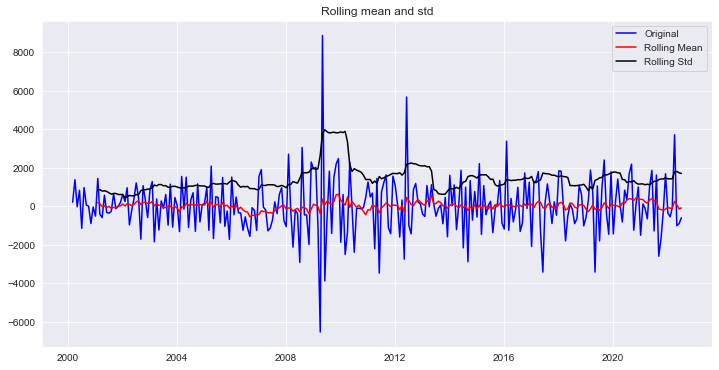

Test Statistic                  -3.881226
p-value                          0.002177
#lags used                      12.000000
number of observations used    256.000000
Critical Value (1%)             -3.456155
Critical Value (5%)             -2.872897
Critical Value (10%)            -2.572822
dtype: float64


In [346]:
stationarity_check(nj_avg.diff().diff()['2000-03-01':])

In [13]:
# 315 zip codes in northern NJ 
final_df.zip.nunique()

315

In [358]:
map_zips(final_df, nj_geo_json, title='Zillow Size Rank', color='YlOrRd')

### Get Top 50 zip codes in Northern NJ

Investor Profile: 
Looking to maximize returns but wants to minimize risk and go with less volatile areas. 

Balance between shorter and longer term returns. 

* long term returns (top 250) 
* shorter (3 year) term returns (top 200) 
* top median yearly returns (top 100) 
* lowest volatility / risk (top 50) 

In [13]:
with open('northern_top.pickle','rb') as f:
    northern_top = pickle.load(f)

In [10]:
"""
Get the top zip codes by long term returns, short term returns, average yearly returns and lowest volatility 
"""

# Long Term Returns
long_term_returns = rankby_total_roi(final_df, num_results=250)

# # 3 year Returns 
three_year_returns = rankby_time_roi(long_term_returns, time_horizon=3, num_results=200)

# # average yearly returns 
median_yearly_returns = rankby_median_annual_roi(three_year_returns, num_results=100)

# # lowest volatility 
volatility = rankby_volatility(median_yearly_returns, num_results=50)

# add roi column 
northern_top = add_roi(volatility) 

print(f'\nTop towns: {northern_top.city.unique()}')
northern_top.head()


Top towns: ['Union' 'Woodbridge Township' 'Clifton' 'Nutley' 'Cedar Grove' 'Oakland'
 'Kenilworth' 'Montclair' 'Fairfield' 'Hardyston Township' 'Wallington'
 'Fanwood' 'Cranford' 'Livingston' 'Ringwood' 'West Caldwell'
 'Vernon Valley' 'Bloomingdale' 'Westfield' 'West Milford' 'Waldwick'
 'Highland Lake' 'Wanaque' 'Little Falls' 'Millburn'
 'Parsippany-Troy Hills Township' 'Mahwah Township' 'Lincoln Park'
 'Pompton Lakes' 'Garwood' 'North Haledon' 'South Plainfield' 'Hawthorne'
 'West Orange' 'Franklin' 'Wantage Township' 'Clark' 'Carlstadt'
 'Rockaway Township' 'Wyckoff' 'Elmwood Park' 'Colonia' 'North Arlington'
 'Riverdale' 'Moonachie']


zip  size_rank                 city                        metro  \
time                                                                            
2000-01-01  7083        938                Union  New York-Newark-Jersey City   
2000-01-01  7064      15984  Woodbridge Township  New York-Newark-Jersey City   
2000-01-01  7012       8559              Clifton  New York-Newark-Jersey City   
2000-01-01  7110       3788               Nutley  New York-Newark-Jersey City   
2000-01-01  7095       6356  Woodbridge Township  New York-Newark-Jersey City   

                      county     price  monthly_roi  roi_multiple  
time                                                               
2000-01-01      Union County  187259.0          0.0           1.0  
2000-01-01  Middlesex County  165936.0          0.0           1.0  
2000-01-01    Passaic County  209781.0          0.0           1.0  
2000-01-01      Essex County  201408.0          0.0           1.0  
2000-01-01  Middlesex County  153619.0          0.0           1.0

In [15]:
print(f'\nTop towns: {northern_top.city.unique()}')


Top towns: ['Union' 'Woodbridge Township' 'Clifton' 'Nutley' 'Cedar Grove' 'Oakland'
 'Kenilworth' 'Montclair' 'Fairfield' 'Hardyston Township' 'Wallington'
 'Fanwood' 'Cranford' 'Livingston' 'Ringwood' 'West Caldwell'
 'Vernon Valley' 'Bloomingdale' 'Westfield' 'West Milford' 'Waldwick'
 'Highland Lake' 'Wanaque' 'Little Falls' 'Millburn'
 'Parsippany-Troy Hills Township' 'Mahwah Township' 'Lincoln Park'
 'Pompton Lakes' 'Garwood' 'North Haledon' 'South Plainfield' 'Hawthorne'
 'West Orange' 'Franklin' 'Wantage Township' 'Clark' 'Carlstadt'
 'Rockaway Township' 'Wyckoff' 'Elmwood Park' 'Colonia' 'North Arlington'
 'Riverdale' 'Moonachie']


In [11]:
# create a dictionary of all zips and towns for displaying information 
zip_dict_northern = {row[1]['zip']:row[1]['city'] for row in northern_top.iterrows()}

In [17]:
map_zips(northern_top, nj_geo_json, title='ROI (2000 - 2022)', color='YlOrRd', col_feature='roi_multiple')

## Train Models on All Zip Codes and Get Forecasts


Getting results for zip: 7083
getting PDQs
Getting results with PDQs


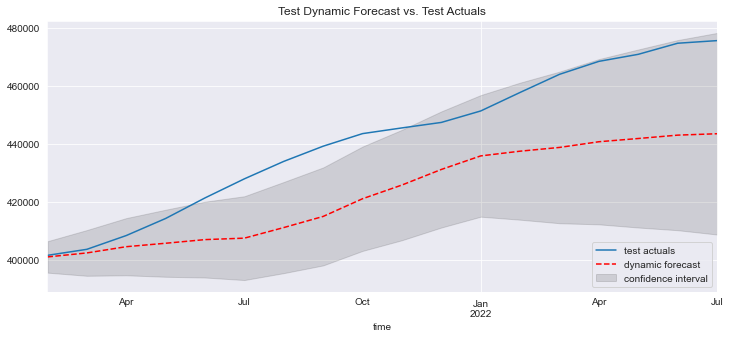

RMSE: 20972.61915256526

Getting results for zip: 7064
getting PDQs
Getting results with PDQs
changing split due to dynamic rmse. New split is 2021-02-01
changing split due to dynamic rmse. New split is 2021-03-01
changing split due to dynamic rmse. New split is 2021-04-01


RMSE: 12314.7373062211

Getting results for zip: 7012
getting PDQs
Getting results with PDQs


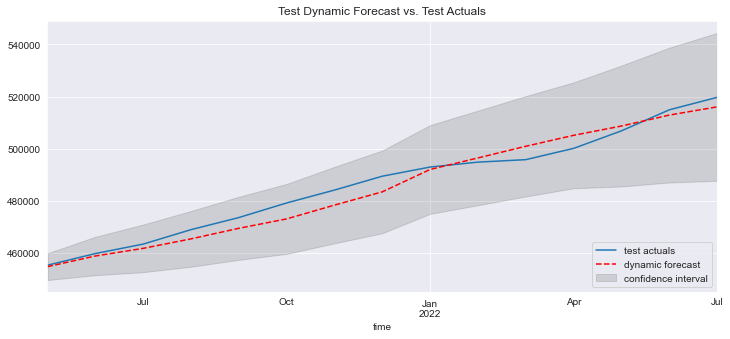

RMSE: 3788.753391373233

Getting results for zip: 7110
getting PDQs
Getting results with PDQs


RMSE: 10695.910748378536

Getting results for zip: 7095
getting PDQs
Getting results with PDQs


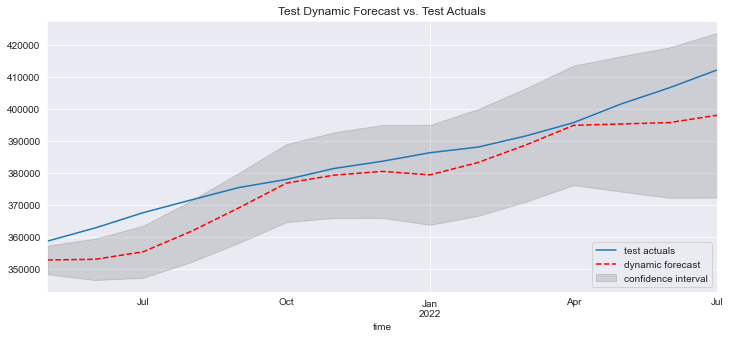

RMSE: 7598.529878941035

Getting results for zip: 7009
getting PDQs
Getting results with PDQs


RMSE: 20919.704050556287

Getting results for zip: 7436
getting PDQs
Getting results with PDQs


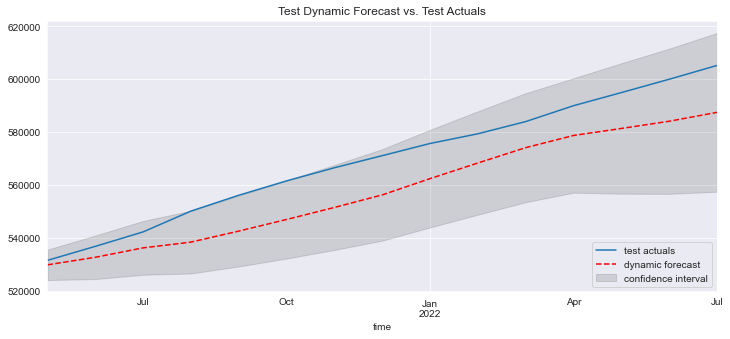

RMSE: 12390.884950443198

Getting results for zip: 7033
getting PDQs
Getting results with PDQs


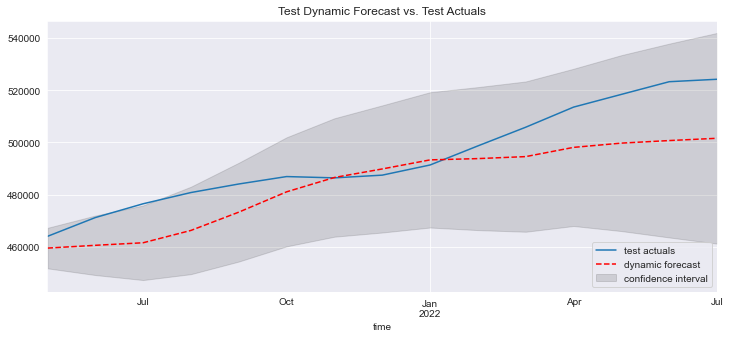

RMSE: 12887.198570715109

Getting results for zip: 7043
getting PDQs
Getting results with PDQs
changing split due to dynamic rmse. New split is 2021-05-01
changing split due to dynamic rmse. New split is 2021-05-01
changing split due to dynamic rmse. New split is 2021-05-01
changing split due to dynamic rmse. New split is 2021-05-01
changing split due to dynamic rmse. New split is 2021-05-01
changing split due to dynamic rmse. New split is 2021-05-01
changing split due to dynamic rmse. New split is 2021-05-01
changing split due to dynamic rmse. New split is 2021-05-01
changing split due to dynamic rmse. New split is 2021-05-01
changing split due to dynamic rmse. New split is 2021-05-01
changing split due to dynamic rmse. New split is 2021-05-01


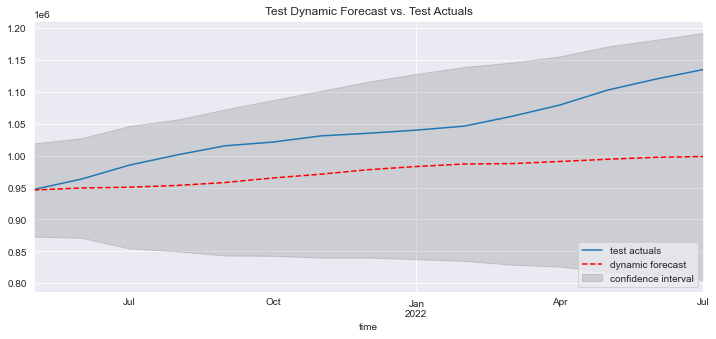

RMSE: 74088.04949103663

Getting results for zip: 7004
getting PDQs
Getting results with PDQs


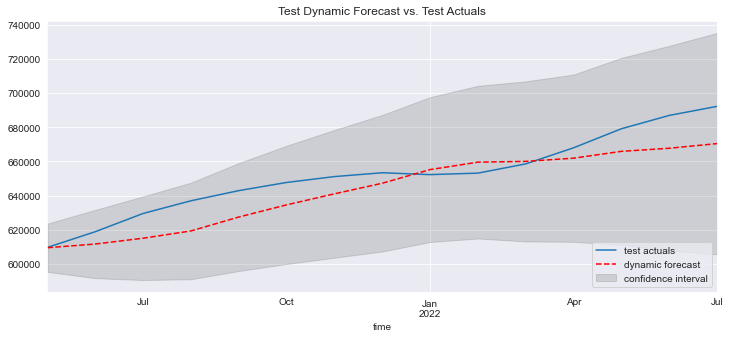

RMSE: 12230.222811673577

Getting results for zip: 7460
getting PDQs
Getting results with PDQs


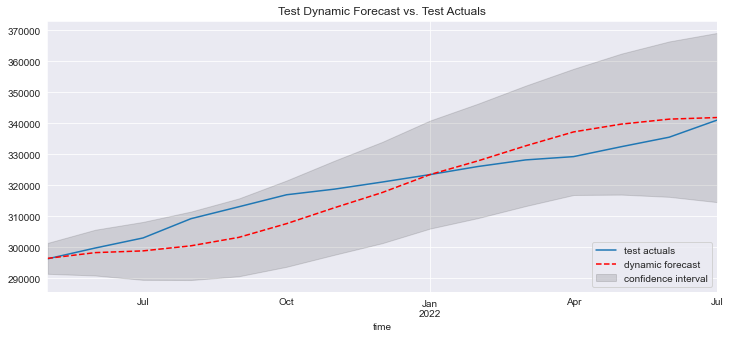

RMSE: 5790.117328394225

Getting results for zip: 7057
getting PDQs
Getting results with PDQs


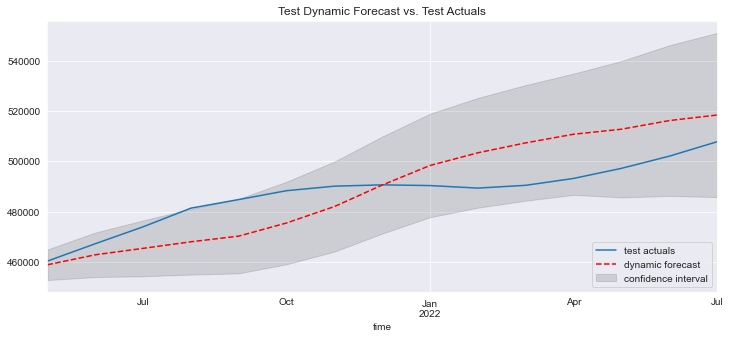

RMSE: 11888.504331594695

Getting results for zip: 7023
getting PDQs
Getting results with PDQs


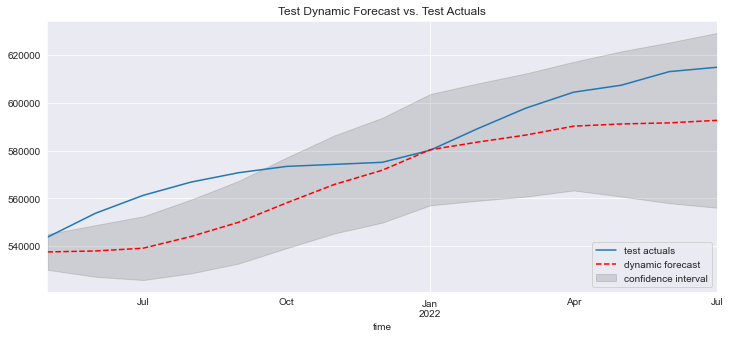

RMSE: 15503.621284196463

Getting results for zip: 7016
getting PDQs
Getting results with PDQs


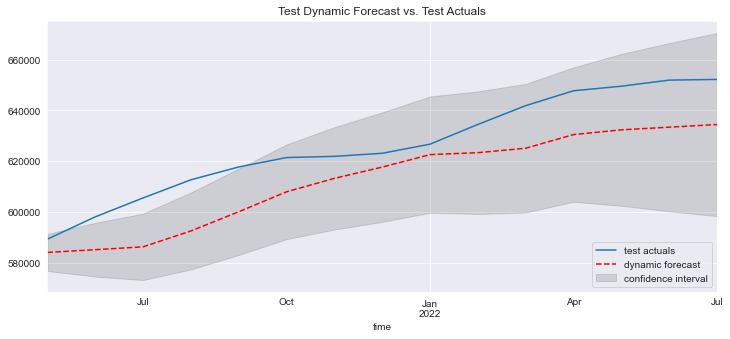

RMSE: 14696.95108701121

Getting results for zip: 7077
getting PDQs
Getting results with PDQs


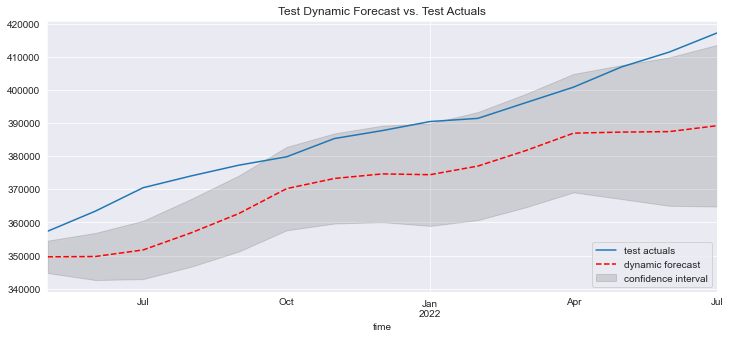

RMSE: 16588.751565293463

Getting results for zip: 7039
getting PDQs
Getting results with PDQs


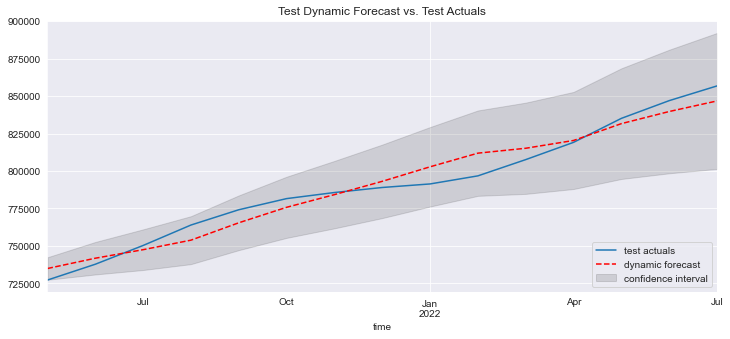

RMSE: 7737.729935042473

Getting results for zip: 7456
getting PDQs
Getting results with PDQs


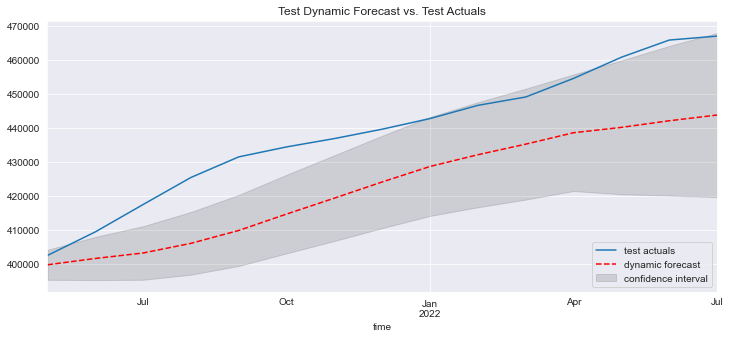

RMSE: 17245.1725559689

Getting results for zip: 7006
getting PDQs
Getting results with PDQs
changing split due to dynamic rmse. New split is 2021-05-01
changing split due to dynamic rmse. New split is 2021-05-01
changing split due to dynamic rmse. New split is 2021-05-01
changing split due to dynamic rmse. New split is 2021-05-01
changing split due to dynamic rmse. New split is 2021-05-01
changing split due to dynamic rmse. New split is 2021-05-01
changing split due to dynamic rmse. New split is 2021-05-01
changing split due to dynamic rmse. New split is 2021-05-01
changing split due to dynamic rmse. New split is 2021-05-01
changing split due to dynamic rmse. New split is 2021-05-01
changing split due to dynamic rmse. New split is 2021-05-01


RMSE: 32812.19430372845

Getting results for zip: 7418
getting PDQs
Getting results with PDQs
Error. Couldn't train model. Returning None LU decomposition error.
results is none.


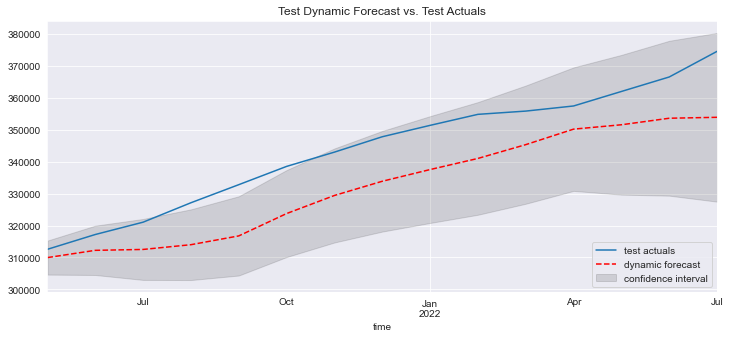

RMSE: 12599.554775679666

Getting results for zip: 7403
getting PDQs
Getting results with PDQs


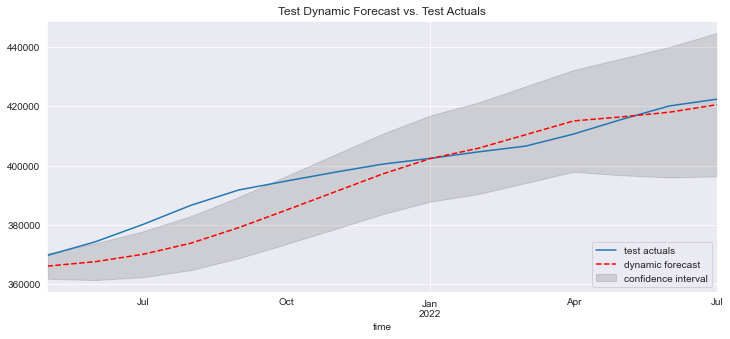

RMSE: 6724.0721593056405

Getting results for zip: 7090
getting PDQs
Getting results with PDQs
changing split due to dynamic rmse. New split is 2021-05-01
changing split due to dynamic rmse. New split is 2021-06-01
changing split due to dynamic rmse. New split is 2021-07-01


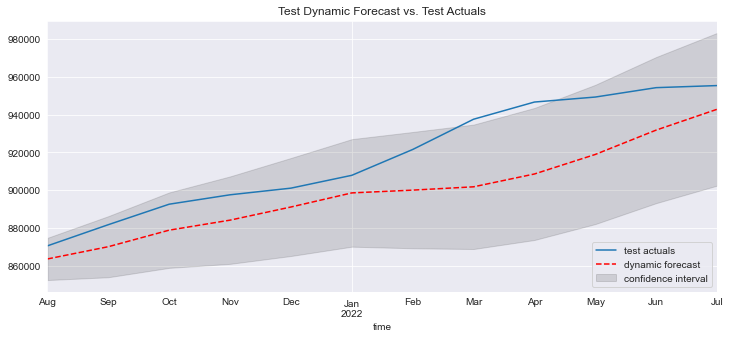

RMSE: 21398.996371698588

Getting results for zip: 7013
getting PDQs
Getting results with PDQs


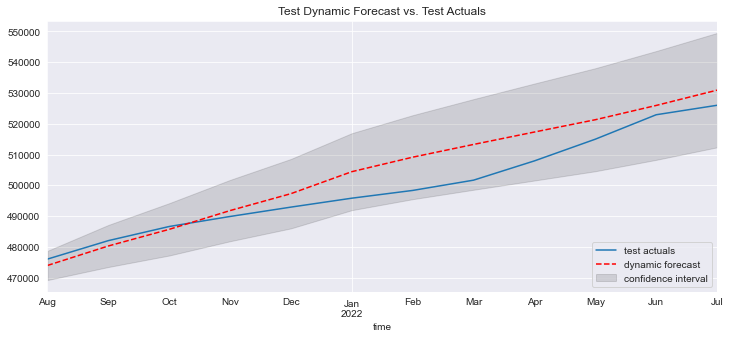

RMSE: 6570.340419552314

Getting results for zip: 7421
getting PDQs
Getting results with PDQs


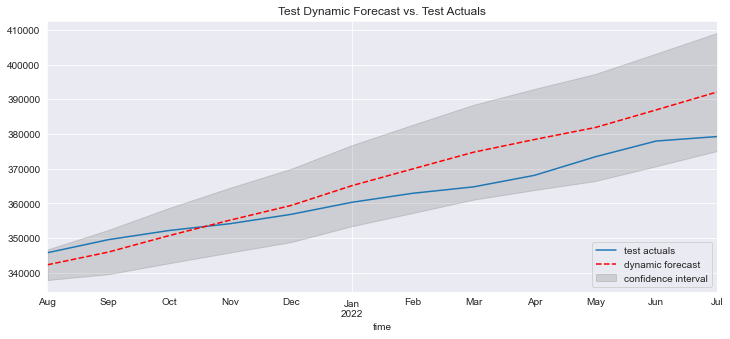

RMSE: 7240.049493287095

Getting results for zip: 7463
getting PDQs
Getting results with PDQs


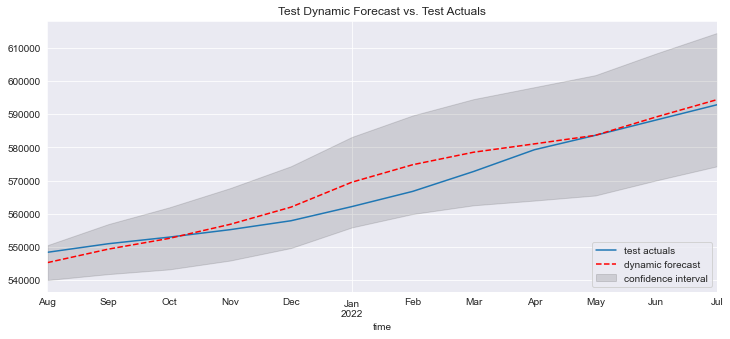

RMSE: 3985.64204717459

Getting results for zip: 7422
getting PDQs
Getting results with PDQs


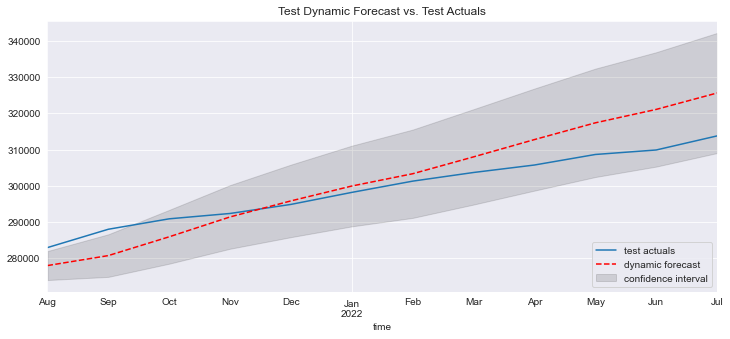

RMSE: 6586.91391811784

Getting results for zip: 7420
getting PDQs
Getting results with PDQs


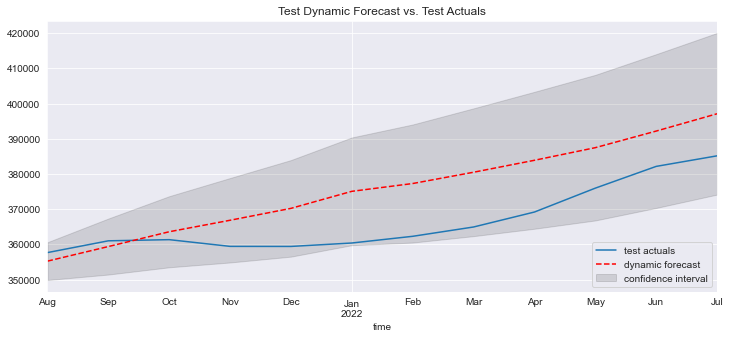

RMSE: 11031.580361931141

Getting results for zip: 7424
getting PDQs
Getting results with PDQs


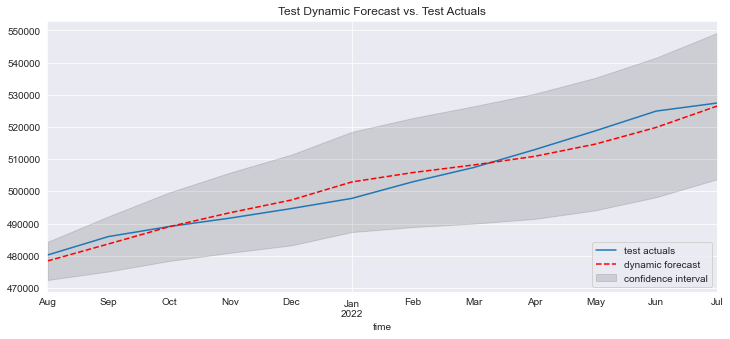

RMSE: 2905.2846888488566

Getting results for zip: 7041
getting PDQs
Getting results with PDQs
changing split due to dynamic rmse. New split is 2021-08-01
changing split due to dynamic rmse. New split is 2021-09-01
changing split due to dynamic rmse. New split is 2021-10-01


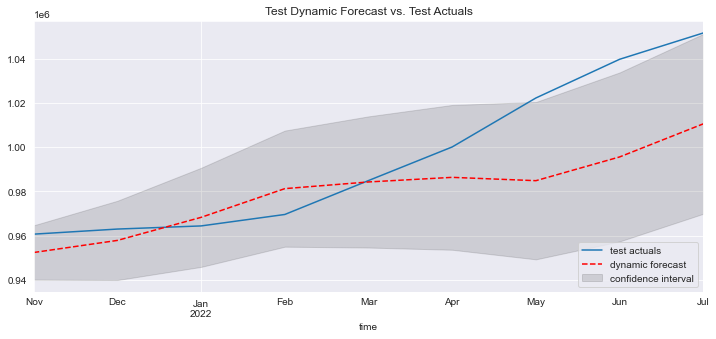

RMSE: 24673.80617484381

Getting results for zip: 7034
getting PDQs
Getting results with PDQs
changing split due to dynamic rmse. New split is 2021-11-01
changing split due to dynamic rmse. New split is 2021-12-01


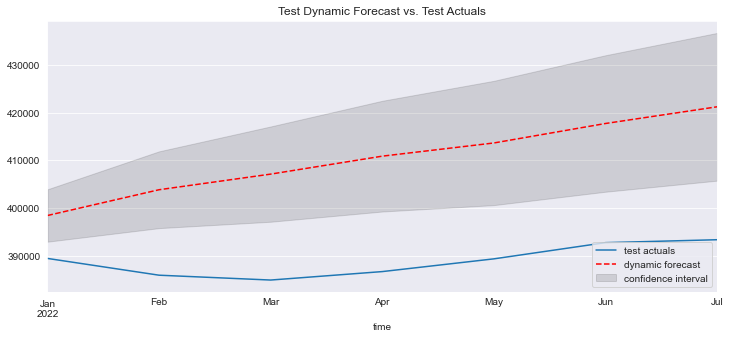

RMSE: 22300.953070084583

Getting results for zip: 7430
getting PDQs
Getting results with PDQs


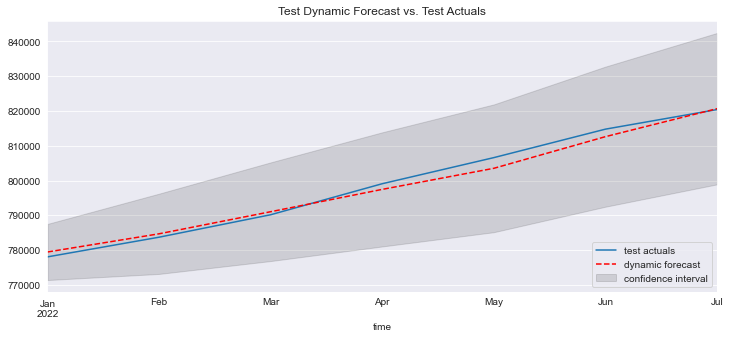

RMSE: 1712.5101486699773

Getting results for zip: 7035
getting PDQs
Getting results with PDQs


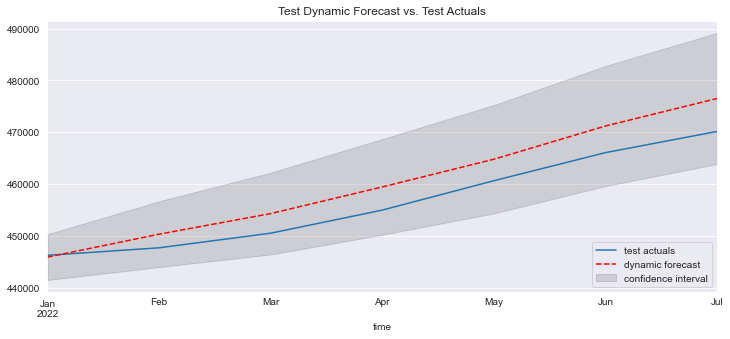

RMSE: 4227.2779921527

Getting results for zip: 7442
getting PDQs
Getting results with PDQs


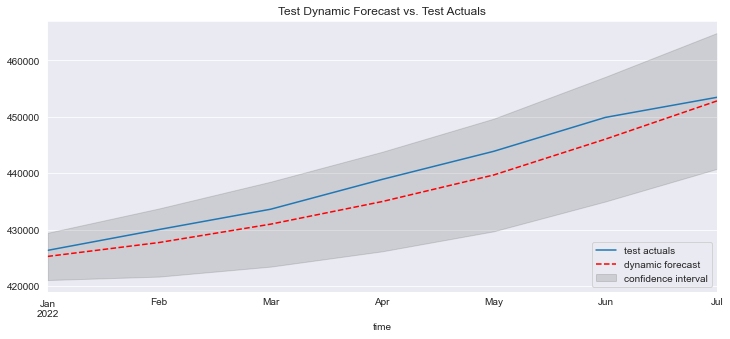

RMSE: 2973.2426640784

Getting results for zip: 7027
getting PDQs
Getting results with PDQs


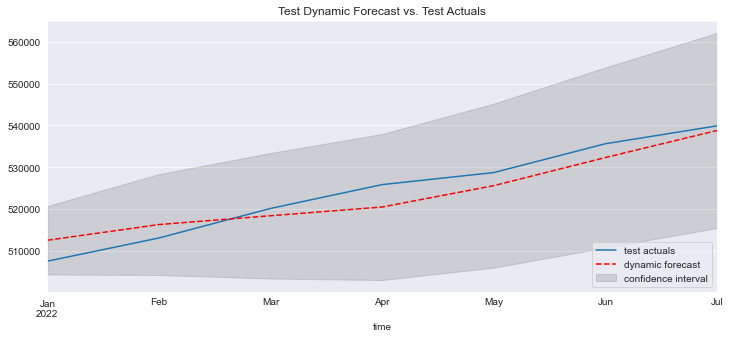

RMSE: 3558.5377948755495

Getting results for zip: 7508
getting PDQs
Getting results with PDQs
Error. Couldn't train model. Returning None LU decomposition error.
results is none.


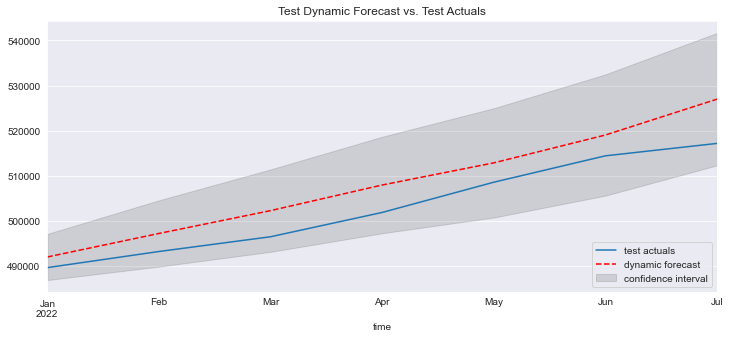

RMSE: 5708.969244482487

Getting results for zip: 7080
getting PDQs
Getting results with PDQs


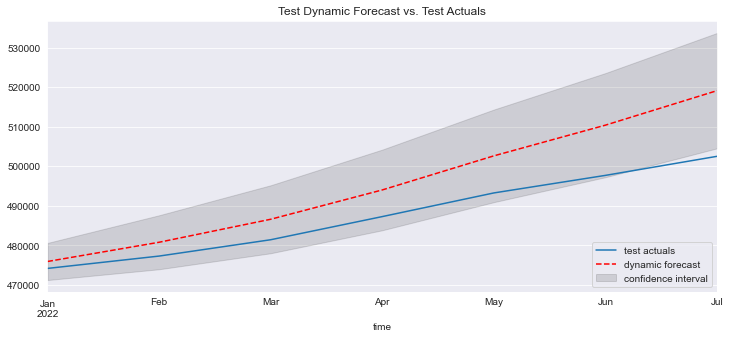

RMSE: 9345.751228548044

Getting results for zip: 7506
getting PDQs
Getting results with PDQs


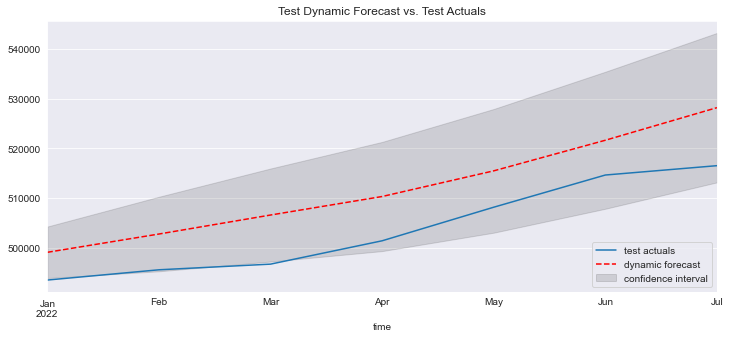

RMSE: 8444.033113140049

Getting results for zip: 7052
getting PDQs
Getting results with PDQs


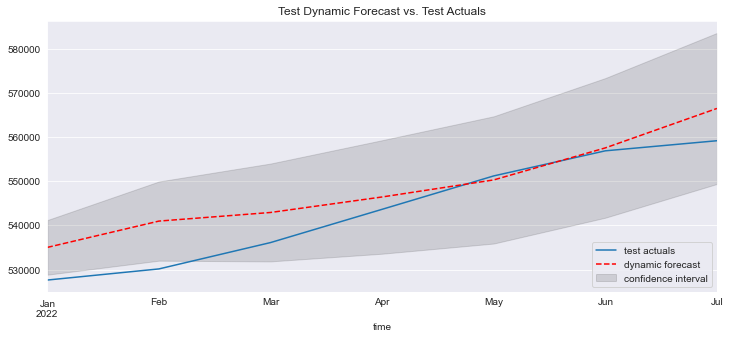

RMSE: 6334.93975647956

Getting results for zip: 7480
getting PDQs
Getting results with PDQs


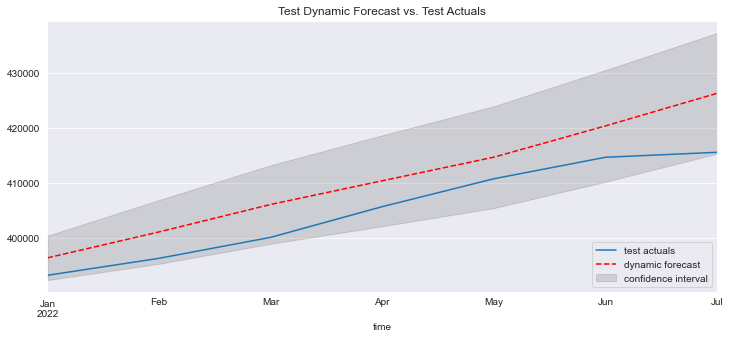

RMSE: 6028.252689842351

Getting results for zip: 7416
getting PDQs
Getting results with PDQs


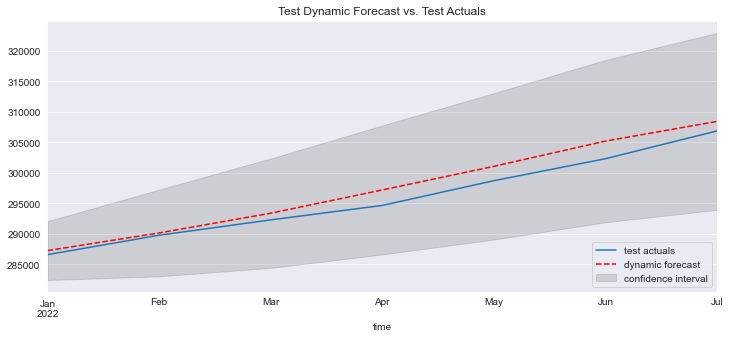

RMSE: 1871.9942557156949

Getting results for zip: 7461
getting PDQs
Getting results with PDQs


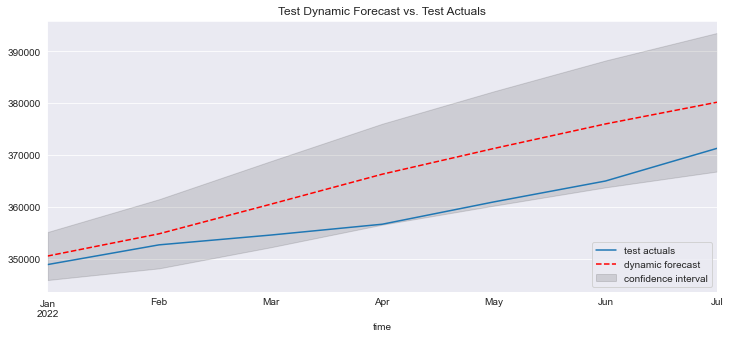

RMSE: 7948.315529802921

Getting results for zip: 7066
getting PDQs
Getting results with PDQs


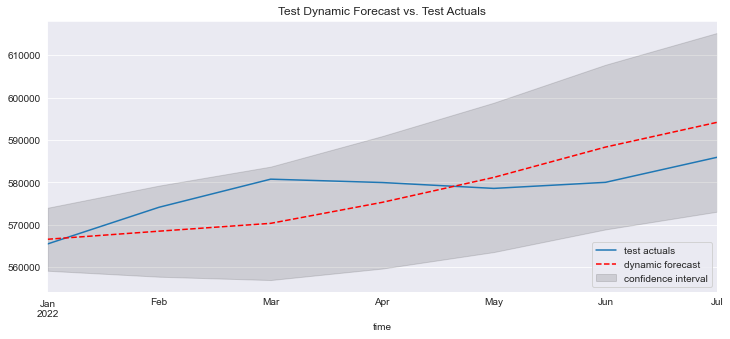

RMSE: 6618.45251993603

Getting results for zip: 7072
getting PDQs
Getting results with PDQs


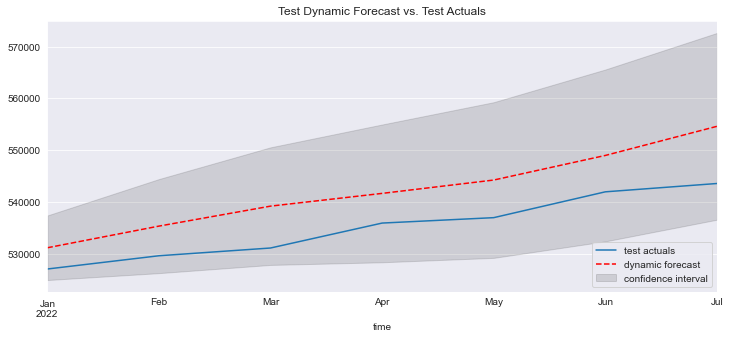

RMSE: 7292.998641455147

Getting results for zip: 7435
getting PDQs
Getting results with PDQs


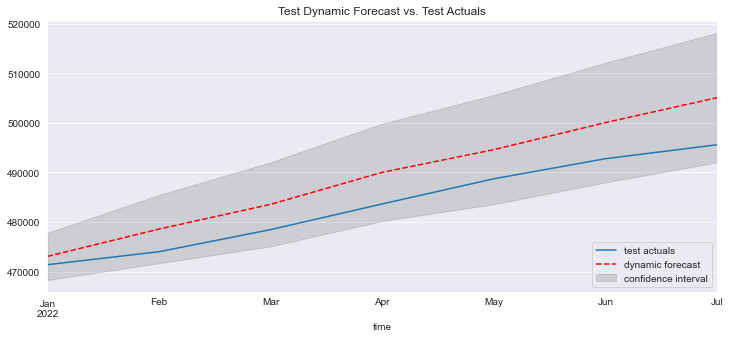

RMSE: 6188.711206495354

Getting results for zip: 7481
getting PDQs
Getting results with PDQs


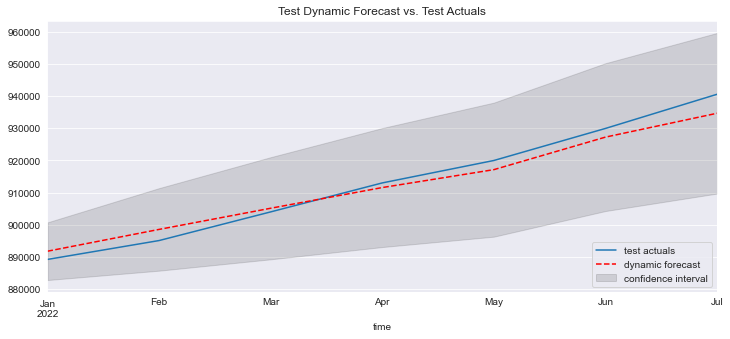

RMSE: 3208.182365216616

Getting results for zip: 7407
getting PDQs
Getting results with PDQs


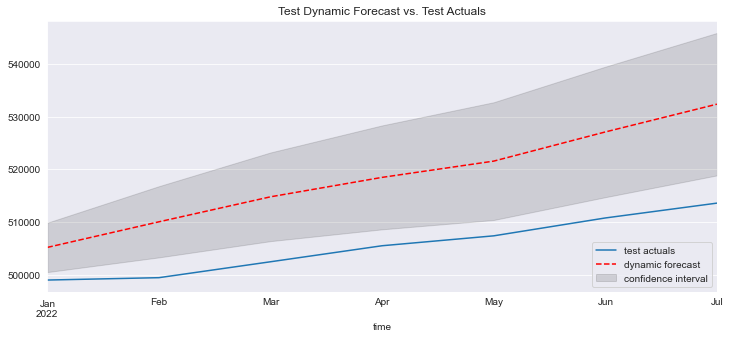

RMSE: 13575.598801088172

Getting results for zip: 7067
getting PDQs
Getting results with PDQs


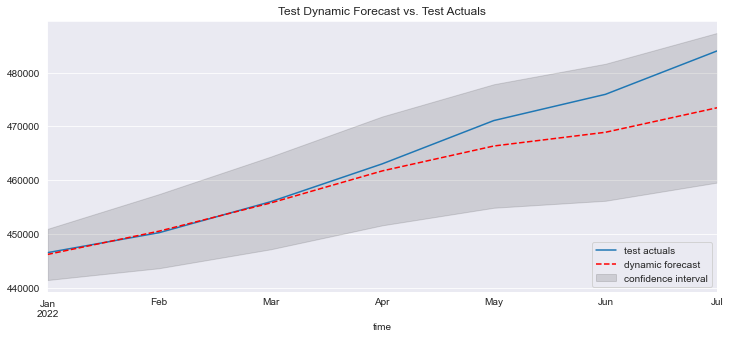

RMSE: 5155.640526844393

Getting results for zip: 7031
getting PDQs
Getting results with PDQs


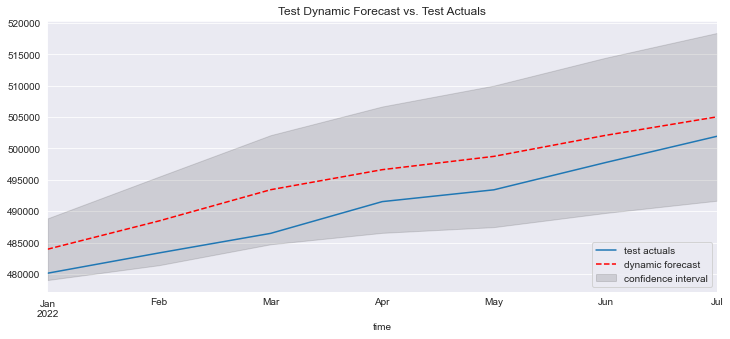

RMSE: 4958.125526331189

Getting results for zip: 7001
getting PDQs
Getting results with PDQs


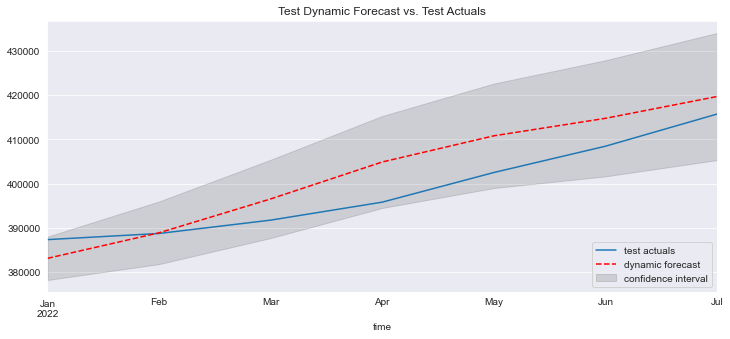

RMSE: 5942.425331587607

Getting results for zip: 7457
getting PDQs
Getting results with PDQs


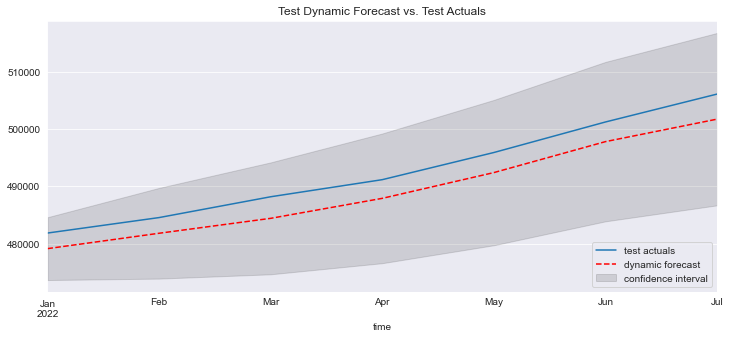

RMSE: 3445.451635262007

Getting results for zip: 7074
getting PDQs
Getting results with PDQs
LinAlgError, 'Singular matrix'. returning None
results is none.


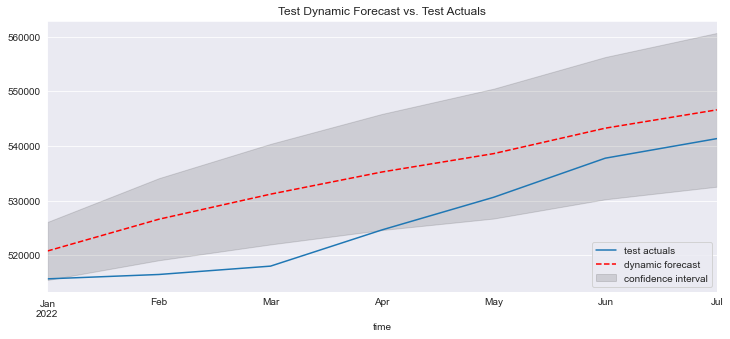

RMSE: 8755.631658849528


In [ ]:
# ONLY NORTHERN NJ 
results_df_northern = get_results(northern_top, split='2021-01-01')

In [233]:
# results if only considering data until 2020 
# get_results(northern_nj[:'2020-12-31'], split='2020-01-01')

In [ ]:
# TODO difference between top zip code if using all data vs post recession data

In [21]:
northern_top.zip.unique()

array([7083, 7064, 7012, 7110, 7095, 7009, 7436, 7033, 7043, 7004, 7460,
       7057, 7023, 7016, 7077, 7039, 7456, 7006, 7418, 7403, 7090, 7013,
       7421, 7463, 7422, 7420, 7424, 7041, 7034, 7430, 7035, 7442, 7027,
       7508, 7080, 7506, 7052, 7480, 7416, 7461, 7066, 7072, 7435, 7481,
       7407, 7067, 7031, 7001, 7457, 7074], dtype=int64)

Splitting at 2021-01-01
Getting results for zip: 7083
(1, 1, 1) (1, 1, 1, 12)
training sarimax
                                     SARIMAX Results                                      
Dep. Variable:                              price   No. Observations:                  253
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2241.601
Date:                            Sun, 11 Sep 2022   AIC                           4493.202
Time:                                    19:41:23   BIC                           4510.606
Sample:                                01-01-2000   HQIC                          4500.215
                                     - 01-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.61

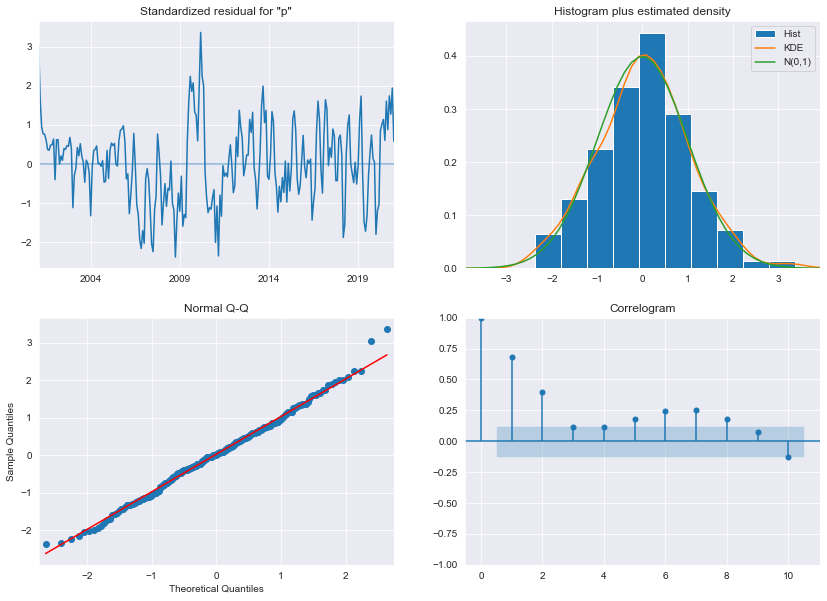

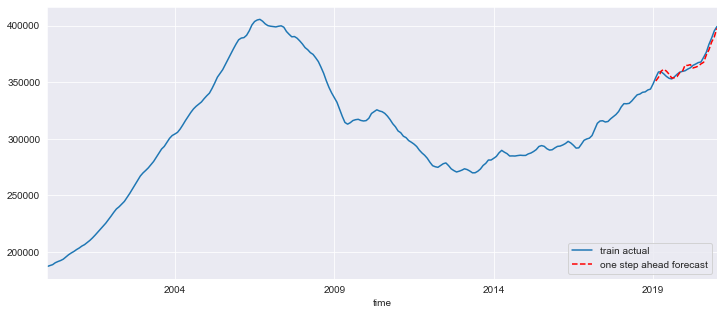

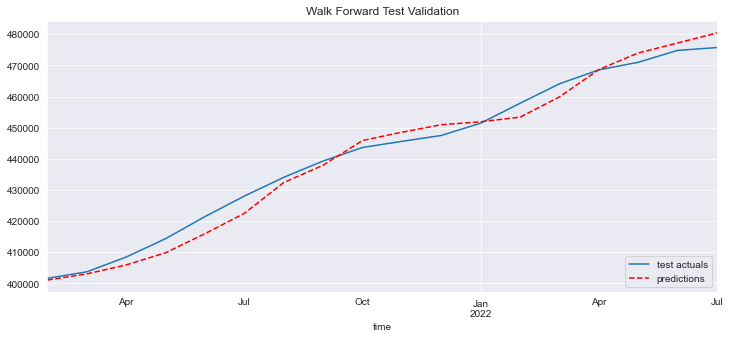

Test RMSE: 3273.512365067326


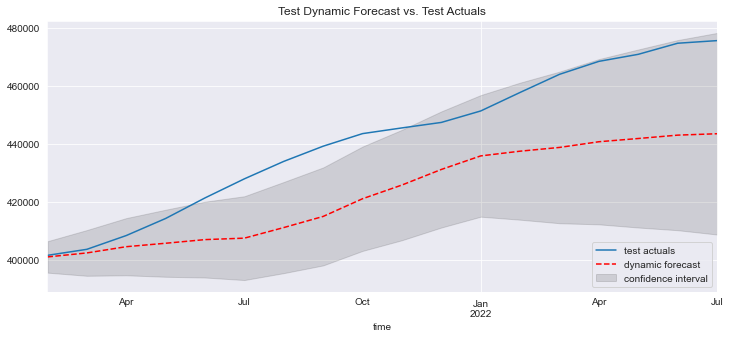

RMSE: 20972.61915256526
Current price: $475734.0, Price after 1 year(s): $517917.08
ROI for 1 year(s):0.08866946948767687

Current price: $475734.0, Price after 3 year(s): $591871.81
ROI for 3 year(s):0.2441234282074739

Current price: $475734.0, Price after 5 year(s): $655513.93
ROI for 5 year(s):0.3779001163666346

Current price: $475734.0, Price after 10 year(s): $787770.38
ROI for 10 year(s):0.6559051534832746



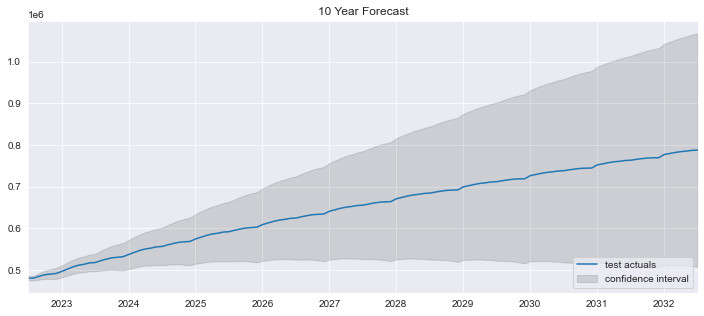

In [19]:
single_zip_analysis(northern_top, 7083, split='2021-01-01')

Splitting at 2021-01-01
Getting results for zip: 7109
(1, 1, 1) (1, 1, 1, 12)
trainign sarimax
                                     SARIMAX Results                                      
Dep. Variable:                              price   No. Observations:                  253
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2182.312
Date:                            Sat, 27 Aug 2022   AIC                           4374.623
Time:                                    21:30:57   BIC                           4392.026
Sample:                                01-01-2000   HQIC                          4381.635
                                     - 01-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.97

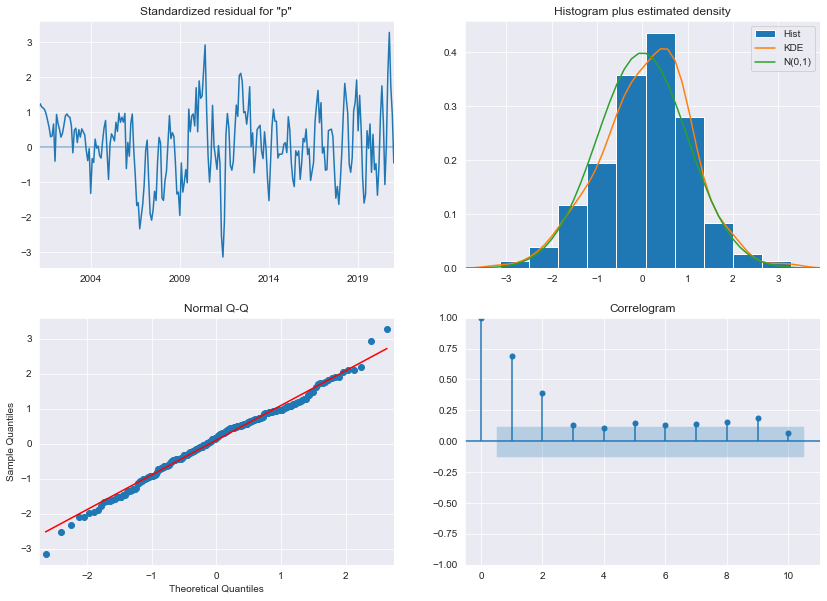

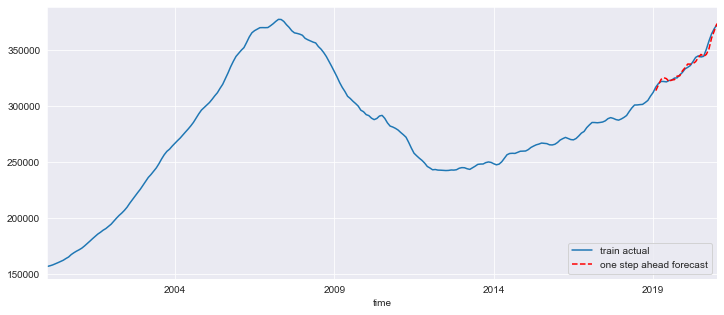

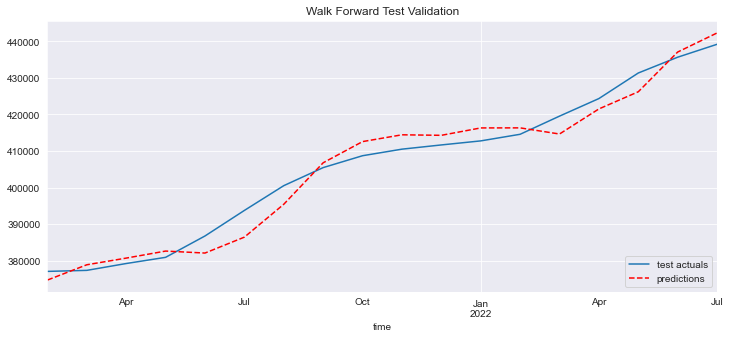

Test RMSE: 3647.2706507264643


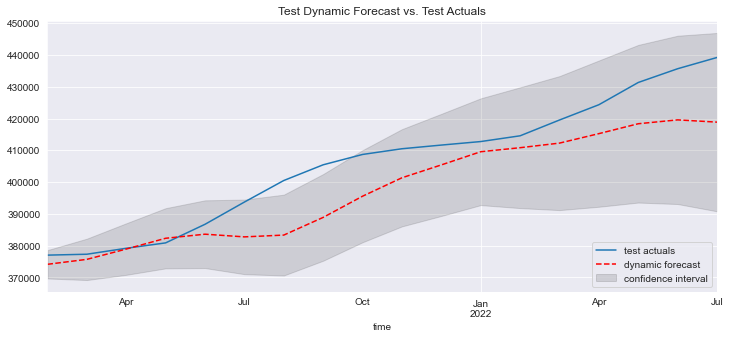

RMSE: 10564.486304191663
Current price: $439229.0, Price after 1 year(s): $481154.95
ROI for 1 year(s):0.09545351788152719

Current price: $439229.0, Price after 3 year(s): $556826.27
ROI for 3 year(s):0.2677356656725081

Current price: $439229.0, Price after 5 year(s): $623935.45
ROI for 5 year(s):0.420524253475798

Current price: $439229.0, Price after 10 year(s): $767235.75
ROI for 10 year(s):0.7467784544326417



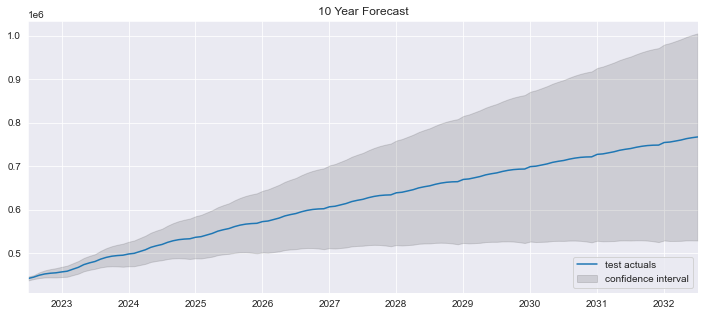

In [99]:
single_zip_analysis(northern_nj_top, 7418, split='2021-01-01')

# Analyze Results

In [4]:
with open('results_df_northern.pickle','rb') as f:
    results_df_northern = pickle.load(f)

In [12]:
results_df_northern = results_df_northern.reset_index()
results_df_northern['town'] = results_df_northern.zip.apply(lambda x: zip_dict_northern[x])

### Get Top Long Term Zips 

In [30]:
top_10_yr_df = results_df_northern.sort_values(by='forecast_10yr_roi', ascending=False).iloc[:5,:]
top_5_yr_df = results_df_northern.sort_values(by='forecast_5yr_roi', ascending=False).iloc[:5,:]
print(top_10_yr_df.zip.unique())
print(top_5_yr_df.zip.unique())


[7039 7080 7442 7013 7456]
[7039 7080 7442 7013 7418]


In [31]:
top_10_yr_df

zip        pdq           pdqs           rmse          aic   train_rmse  \
15  7039  (1, 1, 1)  (1, 1, 1, 12)  139522.997772  4801.320655  7548.546549   
34  7080  (1, 1, 1)  (1, 1, 1, 12)   28726.222038  4625.306841  3411.076916   
31  7442  (1, 1, 1)  (1, 1, 0, 12)    43462.97745   4581.76408  2453.939877   
21  7013  (1, 1, 1)  (1, 1, 1, 12)   62514.306821  4541.010053  2591.155268   
16  7456  (1, 1, 1)  (1, 1, 0, 12)   44224.472236  4436.284396  2277.499283   

      test_rmse  dynamic_rmse  current_price  forecast_1yr_price  \
15  6563.587126   7737.729935       856791.0       980374.560527   
34  1845.834360   9345.751229       502525.0       556353.464775   
31  1509.196051   2973.242664       453457.0       510867.926716   
21  2447.020034   6570.340420       526011.0       583590.615391   
16  3318.141394  17245.172556       467065.0       516205.698176   

    forecast_3yr_price  forecast_5yr_price  forecast_10yr_price  \
15        1.266799e+06        1.590679e+06         2.491404e+06   
34        6.806686e+05        8.267029e+05         1.283134e+06   
31        6.257110e+05        7.405534e+05         1.027659e+06   
21        6.989286e+05        8.142472e+05         1.102371e+06   
16        6.142462e+05        7.122546e+05         9.572724e+05   

    forecast_1yr_roi  forecast_3yr_roi  forecast_5yr_roi  forecast_10yr_roi  \
15          0.144240          0.478539          0.856554           1.907832   
34          0.107116          0.354497          0.645098           1.553373   
31          0.126607          0.379868          0.633128           1.266277   
21          0.109465          0.328734          0.547966           1.095719   
16          0.105212          0.315119          0.524958           1.049549   

                town  
15        Livingston  
34  South Plainfield  
31     Pompton Lakes  
21           Clifton  
16          Ringwood

In [38]:
long_term_df = top_10_yr_df[['zip','town','forecast_10yr_roi','forecast_10yr_price']].reset_index().drop('index', axis=1)
long_term_df

zip              town  forecast_10yr_roi  forecast_10yr_price
0  7039        Livingston           1.907832         2.491404e+06
1  7080  South Plainfield           1.553373         1.283134e+06
2  7442     Pompton Lakes           1.266277         1.027659e+06
3  7013           Clifton           1.095719         1.102371e+06
4  7456          Ringwood           1.049549         9.572724e+05

### Get Top Short Term Zips 

In [14]:
top_3_yr_df = results_df_northern.sort_values(by='forecast_3yr_roi', ascending=False).iloc[:5,:]

print(top_3_yr_df.zip.unique())

[7039 7442 7080 7418 7012]


In [15]:
top_3_yr_df

index   zip        pdq           pdqs           rmse          aic  \
15     15  7039  (1, 1, 1)  (1, 1, 1, 12)  139522.997772  4801.320655   
31     31  7442  (1, 1, 1)  (1, 1, 0, 12)    43462.97745   4581.76408   
34     34  7080  (1, 1, 1)  (1, 1, 1, 12)   28726.222038  4625.306841   
18     18  7418  (1, 1, 0)  (1, 1, 1, 12)   39178.345214  4546.421186   
2       2  7012  (1, 1, 1)  (1, 1, 1, 12)   48474.833615  4528.918353   

     train_rmse    test_rmse  dynamic_rmse  current_price  forecast_1yr_price  \
15  7548.546549  6563.587126   7737.729935       856791.0       980374.560527   
31  2453.939877  1509.196051   2973.242664       453457.0       510867.926716   
34  3411.076916  1845.834360   9345.751229       502525.0       556353.464775   
18  3399.718530  2748.210701  12599.554776       374587.0       422941.875077   
2   2177.128161  2429.409244   3788.753391       519736.0       577264.838459   

    forecast_3yr_price  forecast_5yr_price  forecast_10yr_price  \
15        1.266799e+06        1.590679e+06         2.491404e+06   
31        6.257110e+05        7.405534e+05         1.027659e+06   
34        6.806686e+05        8.267029e+05         1.283134e+06   
18        5.066784e+05        5.774853e+05         7.205164e+05   
2         6.906463e+05        7.967180e+05         1.018869e+06   

    forecast_1yr_roi  forecast_3yr_roi  forecast_5yr_roi  forecast_10yr_roi  \
15          0.144240          0.478539          0.856554           1.907832   
31          0.126607          0.379868          0.633128           1.266277   
34          0.107116          0.354497          0.645098           1.553373   
18          0.129089          0.352632          0.541659           0.923495   
2           0.110689          0.328841          0.532928           0.960359   

                town  
15        Livingston  
31     Pompton Lakes  
34  South Plainfield  
18     Vernon Valley  
2            Clifton

In [16]:
short_term_df = top_3_yr_df[['zip','town','forecast_3yr_roi','forecast_3yr_price']].reset_index().drop('index', axis=1)
short_term_df

zip              town  forecast_3yr_roi  forecast_3yr_price
0  7039        Livingston          0.478539        1.266799e+06
1  7442     Pompton Lakes          0.379868        6.257110e+05
2  7080  South Plainfield          0.354497        6.806686e+05
3  7418     Vernon Valley          0.352632        5.066784e+05
4  7012           Clifton          0.328841        6.906463e+05

### Plot points on Map

In [36]:
map_zips(long_term_df, nj_geo_json, title='10 Year ROI (2032)', col_feature='forecast_10yr_roi', color='YlOrRd')

In [18]:
map_zips(short_term_df, nj_geo_json, title='3 Year ROI (2025)', col_feature='forecast_3yr_roi', color='YlOrRd')

In [ ]:
# Notice the points fall along a line in the middle of the graph, 
# but curve off in the extremities. Normal Q-Q plots that exhibit this 
# behavior usually mean your data have more extreme values than would be expected if they truly came from a Normal distribution.
# https://data.library.virginia.edu/understanding-q-q-plots/
